CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [2]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import time


# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [3]:
X_train = np.load(DATA_PATH + 'X_train_aug.npy')
y_train = np.load(DATA_PATH + 'y_train_aug.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((330, 512, 512, 1), (330, 512, 512, 1), (30, 512, 512, 1))

In [4]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((297, 512, 512, 1), (33, 512, 512, 1), (297, 512, 512, 1), (33, 512, 512, 1))

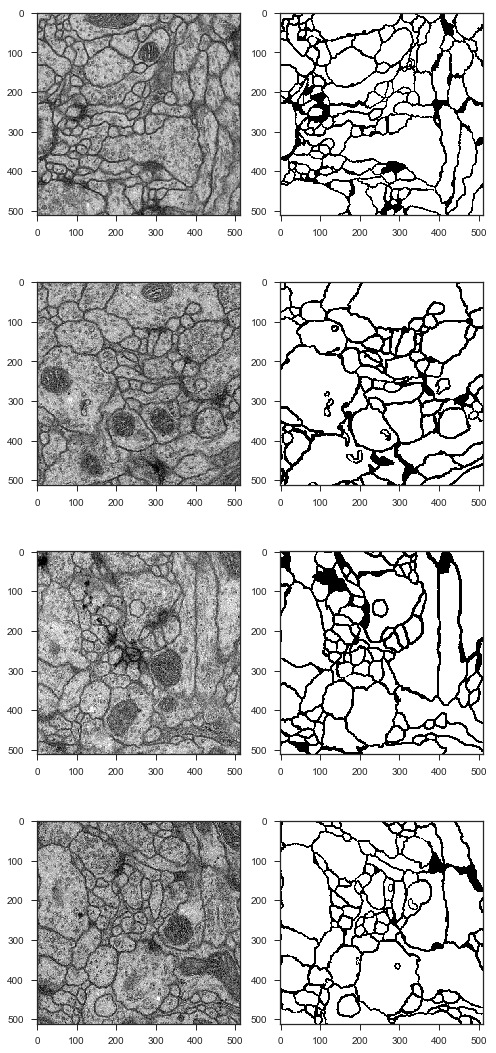

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 19))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [16]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import load_model

from Loss_Functions import cross_entropy_balanced
from U_Net import u_net_fuse_v4, u_net_fuse_v3, u_net_fuse_v5
from Loss_Functions import dice_coef, dice_coef_loss, jaccard_coef, pixel_error

In [10]:
model_u_net_fuse_v4 = u_net_fuse_v4(input_shape=(512, 512, 1))
model_u_net_fuse_v4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1664        lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [11]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v4', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_u_net_fuse_v4.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'o5': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_u_net_fuse_v4.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=100, callbacks=callback_list, verbose=2)

Train on 297 samples, validate on 33 samples


Epoch 1/100


 - 70s - loss: -2.6006e+00 - o1_loss: -4.0069e-01 - o2_loss: -4.1064e-01 - o3_loss: -4.2383e-01 - o4_loss: -3.7522e-01 - o5_loss: -5.6215e-01 - ofuse_loss: -4.2806e-01 - ofuse_dice_coef: 0.4281 - ofuse_jaccard_coef: 0.2747 - ofuse_pixel_error: 0.4086 - val_loss: -2.9012e+00 - val_o1_loss: -3.9488e-01 - val_o2_loss: -4.2574e-01 - val_o3_loss: -5.0897e-01 - val_o4_loss: -4.7470e-01 - val_o5_loss: -6.0390e-01 - val_ofuse_loss: -4.9303e-01 - val_ofuse_dice_coef: 0.4930 - val_ofuse_jaccard_coef: 0.3258 - val_ofuse_pixel_error: 0.2618



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.26175, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 44s - loss: -3.6191e+00 - o1_loss: -4.8500e-01 - o2_loss: -5.5449e-01 - o3_loss: -6.2244e-01 - o4_loss: -6.1265e-01 - o5_loss: -7.2624e-01 - ofuse_loss: -6.1834e-01 - ofuse_dice_coef: 0.6183 - ofuse_jaccard_coef: 0.4474 - ofuse_pixel_error: 0.2289 - val_loss: -3.7359e+00 - val_o1_loss: -4.8673e-01 - val_o2_loss: -5.6092e-01 - val_o3_loss: -6.5060e-01 - val_o4_loss: -6.6463e-01 - val_o5_loss: -7.1316e-01 - val_ofuse_loss: -6.5989e-01 - val_ofuse_dice_coef: 0.6599 - val_ofuse_jaccard_coef: 0.4917 - val_ofuse_pixel_error: 0.1914



Epoch 00002: val_ofuse_pixel_error improved from 0.26175 to 0.19144, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/100


 - 44s - loss: -4.0696e+00 - o1_loss: -5.0754e-01 - o2_loss: -6.1714e-01 - o3_loss: -7.0075e-01 - o4_loss: -7.4747e-01 - o5_loss: -7.8581e-01 - ofuse_loss: -7.1089e-01 - ofuse_dice_coef: 0.7109 - ofuse_jaccard_coef: 0.5509 - ofuse_pixel_error: 0.1521 - val_loss: -3.8975e+00 - val_o1_loss: -4.9084e-01 - val_o2_loss: -5.8788e-01 - val_o3_loss: -6.6694e-01 - val_o4_loss: -7.1470e-01 - val_o5_loss: -7.2441e-01 - val_ofuse_loss: -7.1269e-01 - val_ofuse_dice_coef: 0.7127 - val_ofuse_jaccard_coef: 0.5531 - val_ofuse_pixel_error: 0.1272



Epoch 00003: val_ofuse_pixel_error improved from 0.19144 to 0.12719, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/100


 - 43s - loss: -4.2600e+00 - o1_loss: -5.1601e-01 - o2_loss: -6.4375e-01 - o3_loss: -7.4719e-01 - o4_loss: -7.7959e-01 - o5_loss: -8.0547e-01 - ofuse_loss: -7.6796e-01 - ofuse_dice_coef: 0.7680 - ofuse_jaccard_coef: 0.6226 - ofuse_pixel_error: 0.1148 - val_loss: -4.1947e+00 - val_o1_loss: -4.7695e-01 - val_o2_loss: -6.3624e-01 - val_o3_loss: -7.4102e-01 - val_o4_loss: -7.7683e-01 - val_o5_loss: -7.9244e-01 - val_ofuse_loss: -7.7126e-01 - val_ofuse_dice_coef: 0.7713 - val_ofuse_jaccard_coef: 0.6268 - val_ofuse_pixel_error: 0.1048



Epoch 00004: val_ofuse_pixel_error improved from 0.12719 to 0.10482, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/100


 - 43s - loss: -4.3451e+00 - o1_loss: -5.2192e-01 - o2_loss: -6.5443e-01 - o3_loss: -7.6971e-01 - o4_loss: -7.9378e-01 - o5_loss: -8.1195e-01 - ofuse_loss: -7.9334e-01 - ofuse_dice_coef: 0.7933 - ofuse_jaccard_coef: 0.6569 - ofuse_pixel_error: 0.0998 - val_loss: -4.3172e+00 - val_o1_loss: -5.2102e-01 - val_o2_loss: -6.3639e-01 - val_o3_loss: -7.6070e-01 - val_o4_loss: -7.9354e-01 - val_o5_loss: -8.0724e-01 - val_ofuse_loss: -7.9829e-01 - val_ofuse_dice_coef: 0.7983 - val_ofuse_jaccard_coef: 0.6636 - val_ofuse_pixel_error: 0.0958



Epoch 00005: val_ofuse_pixel_error improved from 0.10482 to 0.09581, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/100


 - 43s - loss: -4.4086e+00 - o1_loss: -5.2775e-01 - o2_loss: -6.6328e-01 - o3_loss: -7.8407e-01 - o4_loss: -8.0534e-01 - o5_loss: -8.1938e-01 - ofuse_loss: -8.0873e-01 - ofuse_dice_coef: 0.8087 - ofuse_jaccard_coef: 0.6780 - ofuse_pixel_error: 0.0909 - val_loss: -4.3585e+00 - val_o1_loss: -5.1984e-01 - val_o2_loss: -6.5543e-01 - val_o3_loss: -7.7861e-01 - val_o4_loss: -7.9807e-01 - val_o5_loss: -8.0753e-01 - val_ofuse_loss: -7.9897e-01 - val_ofuse_dice_coef: 0.7990 - val_ofuse_jaccard_coef: 0.6648 - val_ofuse_pixel_error: 0.0974



Epoch 00006: val_ofuse_pixel_error did not improve
Epoch 7/100


 - 43s - loss: -4.4510e+00 - o1_loss: -5.3217e-01 - o2_loss: -6.6947e-01 - o3_loss: -7.9258e-01 - o4_loss: -8.1367e-01 - o5_loss: -8.2489e-01 - ofuse_loss: -8.1821e-01 - ofuse_dice_coef: 0.8182 - ofuse_jaccard_coef: 0.6914 - ofuse_pixel_error: 0.0856 - val_loss: -4.3077e+00 - val_o1_loss: -5.0158e-01 - val_o2_loss: -6.4222e-01 - val_o3_loss: -7.6877e-01 - val_o4_loss: -7.9442e-01 - val_o5_loss: -8.0202e-01 - val_ofuse_loss: -7.9872e-01 - val_ofuse_dice_coef: 0.7987 - val_ofuse_jaccard_coef: 0.6647 - val_ofuse_pixel_error: 0.0899



Epoch 00007: val_ofuse_pixel_error improved from 0.09581 to 0.08988, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/100


 - 43s - loss: -4.4591e+00 - o1_loss: -5.3276e-01 - o2_loss: -6.7025e-01 - o3_loss: -7.9394e-01 - o4_loss: -8.1626e-01 - o5_loss: -8.2541e-01 - ofuse_loss: -8.2046e-01 - ofuse_dice_coef: 0.8205 - ofuse_jaccard_coef: 0.6945 - ofuse_pixel_error: 0.0841 - val_loss: -4.3762e+00 - val_o1_loss: -5.2575e-01 - val_o2_loss: -6.5749e-01 - val_o3_loss: -7.7442e-01 - val_o4_loss: -8.0261e-01 - val_o5_loss: -8.1045e-01 - val_ofuse_loss: -8.0548e-01 - val_ofuse_dice_coef: 0.8055 - val_ofuse_jaccard_coef: 0.6741 - val_ofuse_pixel_error: 0.0897



Epoch 00008: val_ofuse_pixel_error improved from 0.08988 to 0.08970, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 9/100


 - 43s - loss: -4.5032e+00 - o1_loss: -5.3730e-01 - o2_loss: -6.7879e-01 - o3_loss: -8.0137e-01 - o4_loss: -8.2476e-01 - o5_loss: -8.3229e-01 - ofuse_loss: -8.2868e-01 - ofuse_dice_coef: 0.8287 - ofuse_jaccard_coef: 0.7065 - ofuse_pixel_error: 0.0796 - val_loss: -4.4705e+00 - val_o1_loss: -5.3244e-01 - val_o2_loss: -6.7352e-01 - val_o3_loss: -7.9359e-01 - val_o4_loss: -8.2051e-01 - val_o5_loss: -8.2776e-01 - val_ofuse_loss: -8.2268e-01 - val_ofuse_dice_coef: 0.8227 - val_ofuse_jaccard_coef: 0.6980 - val_ofuse_pixel_error: 0.0842



Epoch 00009: val_ofuse_pixel_error improved from 0.08970 to 0.08416, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/100


 - 43s - loss: -4.5260e+00 - o1_loss: -5.4086e-01 - o2_loss: -6.8270e-01 - o3_loss: -8.0518e-01 - o4_loss: -8.2970e-01 - o5_loss: -8.3520e-01 - ofuse_loss: -8.3238e-01 - ofuse_dice_coef: 0.8324 - ofuse_jaccard_coef: 0.7118 - ofuse_pixel_error: 0.0776 - val_loss: -4.4813e+00 - val_o1_loss: -5.3483e-01 - val_o2_loss: -6.7142e-01 - val_o3_loss: -7.9572e-01 - val_o4_loss: -8.2483e-01 - val_o5_loss: -8.3024e-01 - val_ofuse_loss: -8.2425e-01 - val_ofuse_dice_coef: 0.8242 - val_ofuse_jaccard_coef: 0.7002 - val_ofuse_pixel_error: 0.0836



Epoch 00010: val_ofuse_pixel_error improved from 0.08416 to 0.08356, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/100


 - 43s - loss: -4.5425e+00 - o1_loss: -5.4292e-01 - o2_loss: -6.8567e-01 - o3_loss: -8.0765e-01 - o4_loss: -8.3340e-01 - o5_loss: -8.3759e-01 - ofuse_loss: -8.3524e-01 - ofuse_dice_coef: 0.8352 - ofuse_jaccard_coef: 0.7160 - ofuse_pixel_error: 0.0759 - val_loss: -4.4876e+00 - val_o1_loss: -5.3769e-01 - val_o2_loss: -6.7614e-01 - val_o3_loss: -7.9614e-01 - val_o4_loss: -8.2392e-01 - val_o5_loss: -8.2911e-01 - val_ofuse_loss: -8.2461e-01 - val_ofuse_dice_coef: 0.8246 - val_ofuse_jaccard_coef: 0.7007 - val_ofuse_pixel_error: 0.0830



Epoch 00011: val_ofuse_pixel_error improved from 0.08356 to 0.08304, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/100


 - 43s - loss: -4.5551e+00 - o1_loss: -5.4501e-01 - o2_loss: -6.8817e-01 - o3_loss: -8.0950e-01 - o4_loss: -8.3572e-01 - o5_loss: -8.3944e-01 - ofuse_loss: -8.3723e-01 - ofuse_dice_coef: 0.8372 - ofuse_jaccard_coef: 0.7190 - ofuse_pixel_error: 0.0750 - val_loss: -4.5083e+00 - val_o1_loss: -5.3861e-01 - val_o2_loss: -6.7346e-01 - val_o3_loss: -8.0269e-01 - val_o4_loss: -8.2947e-01 - val_o5_loss: -8.3350e-01 - val_ofuse_loss: -8.3057e-01 - val_ofuse_dice_coef: 0.8306 - val_ofuse_jaccard_coef: 0.7098 - val_ofuse_pixel_error: 0.0804



Epoch 00012: val_ofuse_pixel_error improved from 0.08304 to 0.08039, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 13/100


 - 44s - loss: -4.5707e+00 - o1_loss: -5.4678e-01 - o2_loss: -6.9142e-01 - o3_loss: -8.1263e-01 - o4_loss: -8.3833e-01 - o5_loss: -8.4166e-01 - ofuse_loss: -8.3986e-01 - ofuse_dice_coef: 0.8399 - ofuse_jaccard_coef: 0.7227 - ofuse_pixel_error: 0.0737 - val_loss: -4.4463e+00 - val_o1_loss: -5.2901e-01 - val_o2_loss: -6.7056e-01 - val_o3_loss: -7.8996e-01 - val_o4_loss: -8.1757e-01 - val_o5_loss: -8.2099e-01 - val_ofuse_loss: -8.1821e-01 - val_ofuse_dice_coef: 0.8182 - val_ofuse_jaccard_coef: 0.6923 - val_ofuse_pixel_error: 0.0835



Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/100


 - 44s - loss: -4.5754e+00 - o1_loss: -5.4824e-01 - o2_loss: -6.9243e-01 - o3_loss: -8.1303e-01 - o4_loss: -8.3915e-01 - o5_loss: -8.4214e-01 - ofuse_loss: -8.4039e-01 - ofuse_dice_coef: 0.8404 - ofuse_jaccard_coef: 0.7237 - ofuse_pixel_error: 0.0734 - val_loss: -4.5257e+00 - val_o1_loss: -5.3976e-01 - val_o2_loss: -6.8489e-01 - val_o3_loss: -8.0304e-01 - val_o4_loss: -8.3173e-01 - val_o5_loss: -8.3359e-01 - val_ofuse_loss: -8.3272e-01 - val_ofuse_dice_coef: 0.8327 - val_ofuse_jaccard_coef: 0.7128 - val_ofuse_pixel_error: 0.0760



Epoch 00014: val_ofuse_pixel_error improved from 0.08039 to 0.07602, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 15/100


 - 44s - loss: -4.5958e+00 - o1_loss: -5.4981e-01 - o2_loss: -6.9587e-01 - o3_loss: -8.1711e-01 - o4_loss: -8.4287e-01 - o5_loss: -8.4572e-01 - ofuse_loss: -8.4437e-01 - ofuse_dice_coef: 0.8444 - ofuse_jaccard_coef: 0.7296 - ofuse_pixel_error: 0.0714 - val_loss: -4.5323e+00 - val_o1_loss: -5.4032e-01 - val_o2_loss: -6.8682e-01 - val_o3_loss: -8.0720e-01 - val_o4_loss: -8.3150e-01 - val_o5_loss: -8.3395e-01 - val_ofuse_loss: -8.3249e-01 - val_ofuse_dice_coef: 0.8325 - val_ofuse_jaccard_coef: 0.7121 - val_ofuse_pixel_error: 0.0792



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/100


 - 43s - loss: -4.6056e+00 - o1_loss: -5.5196e-01 - o2_loss: -6.9768e-01 - o3_loss: -8.1893e-01 - o4_loss: -8.4431e-01 - o5_loss: -8.4703e-01 - ofuse_loss: -8.4573e-01 - ofuse_dice_coef: 0.8457 - ofuse_jaccard_coef: 0.7316 - ofuse_pixel_error: 0.0709 - val_loss: -4.4864e+00 - val_o1_loss: -5.3795e-01 - val_o2_loss: -6.7577e-01 - val_o3_loss: -7.9722e-01 - val_o4_loss: -8.2384e-01 - val_o5_loss: -8.2653e-01 - val_ofuse_loss: -8.2505e-01 - val_ofuse_dice_coef: 0.8251 - val_ofuse_jaccard_coef: 0.7016 - val_ofuse_pixel_error: 0.0827



Epoch 00016: val_ofuse_pixel_error did not improve
Epoch 17/100


 - 43s - loss: -4.6073e+00 - o1_loss: -5.5165e-01 - o2_loss: -6.9779e-01 - o3_loss: -8.1929e-01 - o4_loss: -8.4485e-01 - o5_loss: -8.4737e-01 - ofuse_loss: -8.4632e-01 - ofuse_dice_coef: 0.8463 - ofuse_jaccard_coef: 0.7325 - ofuse_pixel_error: 0.0705 - val_loss: -4.5407e+00 - val_o1_loss: -5.4290e-01 - val_o2_loss: -6.8869e-01 - val_o3_loss: -8.0626e-01 - val_o4_loss: -8.3313e-01 - val_o5_loss: -8.3600e-01 - val_ofuse_loss: -8.3372e-01 - val_ofuse_dice_coef: 0.8337 - val_ofuse_jaccard_coef: 0.7140 - val_ofuse_pixel_error: 0.0788



Epoch 00017: val_ofuse_pixel_error did not improve
Epoch 18/100


 - 45s - loss: -4.6103e+00 - o1_loss: -5.5195e-01 - o2_loss: -6.9848e-01 - o3_loss: -8.1971e-01 - o4_loss: -8.4545e-01 - o5_loss: -8.4785e-01 - ofuse_loss: -8.4685e-01 - ofuse_dice_coef: 0.8469 - ofuse_jaccard_coef: 0.7333 - ofuse_pixel_error: 0.0703 - val_loss: -4.5246e+00 - val_o1_loss: -5.4075e-01 - val_o2_loss: -6.8502e-01 - val_o3_loss: -8.0312e-01 - val_o4_loss: -8.3110e-01 - val_o5_loss: -8.3234e-01 - val_ofuse_loss: -8.3225e-01 - val_ofuse_dice_coef: 0.8323 - val_ofuse_jaccard_coef: 0.7122 - val_ofuse_pixel_error: 0.0784



Epoch 00018: val_ofuse_pixel_error did not improve
Epoch 19/100


 - 44s - loss: -4.6374e+00 - o1_loss: -5.5481e-01 - o2_loss: -7.0321e-01 - o3_loss: -8.2487e-01 - o4_loss: -8.5014e-01 - o5_loss: -8.5255e-01 - ofuse_loss: -8.5179e-01 - ofuse_dice_coef: 0.8518 - ofuse_jaccard_coef: 0.7408 - ofuse_pixel_error: 0.0679 - val_loss: -4.5578e+00 - val_o1_loss: -5.4272e-01 - val_o2_loss: -6.9045e-01 - val_o3_loss: -8.0891e-01 - val_o4_loss: -8.3721e-01 - val_o5_loss: -8.4025e-01 - val_ofuse_loss: -8.3825e-01 - val_ofuse_dice_coef: 0.8382 - val_ofuse_jaccard_coef: 0.7206 - val_ofuse_pixel_error: 0.0747



Epoch 00019: val_ofuse_pixel_error improved from 0.07602 to 0.07472, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 20/100


 - 43s - loss: -4.6389e+00 - o1_loss: -5.5614e-01 - o2_loss: -7.0323e-01 - o3_loss: -8.2447e-01 - o4_loss: -8.5044e-01 - o5_loss: -8.5274e-01 - ofuse_loss: -8.5185e-01 - ofuse_dice_coef: 0.8519 - ofuse_jaccard_coef: 0.7409 - ofuse_pixel_error: 0.0679 - val_loss: -4.5670e+00 - val_o1_loss: -5.4599e-01 - val_o2_loss: -6.9185e-01 - val_o3_loss: -8.1293e-01 - val_o4_loss: -8.3762e-01 - val_o5_loss: -8.3877e-01 - val_ofuse_loss: -8.3981e-01 - val_ofuse_dice_coef: 0.8398 - val_ofuse_jaccard_coef: 0.7230 - val_ofuse_pixel_error: 0.0747



Epoch 00020: val_ofuse_pixel_error did not improve
Epoch 21/100


 - 43s - loss: -4.6631e+00 - o1_loss: -5.5811e-01 - o2_loss: -7.0734e-01 - o3_loss: -8.2970e-01 - o4_loss: -8.5469e-01 - o5_loss: -8.5688e-01 - ofuse_loss: -8.5640e-01 - ofuse_dice_coef: 0.8564 - ofuse_jaccard_coef: 0.7477 - ofuse_pixel_error: 0.0656 - val_loss: -4.5730e+00 - val_o1_loss: -5.4569e-01 - val_o2_loss: -6.9436e-01 - val_o3_loss: -8.1329e-01 - val_o4_loss: -8.3852e-01 - val_o5_loss: -8.4133e-01 - val_ofuse_loss: -8.3984e-01 - val_ofuse_dice_coef: 0.8398 - val_ofuse_jaccard_coef: 0.7231 - val_ofuse_pixel_error: 0.0748



Epoch 00021: val_ofuse_pixel_error did not improve
Epoch 22/100


 - 43s - loss: -4.6726e+00 - o1_loss: -5.5936e-01 - o2_loss: -7.0889e-01 - o3_loss: -8.3113e-01 - o4_loss: -8.5643e-01 - o5_loss: -8.5868e-01 - ofuse_loss: -8.5806e-01 - ofuse_dice_coef: 0.8581 - ofuse_jaccard_coef: 0.7503 - ofuse_pixel_error: 0.0648 - val_loss: -4.5359e+00 - val_o1_loss: -5.4429e-01 - val_o2_loss: -6.8586e-01 - val_o3_loss: -8.0678e-01 - val_o4_loss: -8.3093e-01 - val_o5_loss: -8.3397e-01 - val_ofuse_loss: -8.3406e-01 - val_ofuse_dice_coef: 0.8341 - val_ofuse_jaccard_coef: 0.7149 - val_ofuse_pixel_error: 0.0755



Epoch 00022: val_ofuse_pixel_error did not improve
Epoch 23/100


 - 43s - loss: -4.6766e+00 - o1_loss: -5.6031e-01 - o2_loss: -7.0922e-01 - o3_loss: -8.3157e-01 - o4_loss: -8.5719e-01 - o5_loss: -8.5945e-01 - ofuse_loss: -8.5890e-01 - ofuse_dice_coef: 0.8589 - ofuse_jaccard_coef: 0.7516 - ofuse_pixel_error: 0.0644 - val_loss: -4.5476e+00 - val_o1_loss: -5.4398e-01 - val_o2_loss: -6.9240e-01 - val_o3_loss: -8.0968e-01 - val_o4_loss: -8.3272e-01 - val_o5_loss: -8.3381e-01 - val_ofuse_loss: -8.3505e-01 - val_ofuse_dice_coef: 0.8351 - val_ofuse_jaccard_coef: 0.7163 - val_ofuse_pixel_error: 0.0738



Epoch 00023: val_ofuse_pixel_error improved from 0.07472 to 0.07384, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 24/100


 - 43s - loss: -4.6857e+00 - o1_loss: -5.6060e-01 - o2_loss: -7.1036e-01 - o3_loss: -8.3359e-01 - o4_loss: -8.5914e-01 - o5_loss: -8.6119e-01 - ofuse_loss: -8.6085e-01 - ofuse_dice_coef: 0.8608 - ofuse_jaccard_coef: 0.7544 - ofuse_pixel_error: 0.0636 - val_loss: -4.5655e+00 - val_o1_loss: -5.4671e-01 - val_o2_loss: -6.9530e-01 - val_o3_loss: -8.1229e-01 - val_o4_loss: -8.3611e-01 - val_o5_loss: -8.3777e-01 - val_ofuse_loss: -8.3730e-01 - val_ofuse_dice_coef: 0.8373 - val_ofuse_jaccard_coef: 0.7192 - val_ofuse_pixel_error: 0.0796



Epoch 00024: val_ofuse_pixel_error did not improve
Epoch 25/100


 - 43s - loss: -4.6964e+00 - o1_loss: -5.6247e-01 - o2_loss: -7.1204e-01 - o3_loss: -8.3540e-01 - o4_loss: -8.6095e-01 - o5_loss: -8.6291e-01 - ofuse_loss: -8.6266e-01 - ofuse_dice_coef: 0.8627 - ofuse_jaccard_coef: 0.7572 - ofuse_pixel_error: 0.0627 - val_loss: -4.5938e+00 - val_o1_loss: -5.4830e-01 - val_o2_loss: -6.9676e-01 - val_o3_loss: -8.1667e-01 - val_o4_loss: -8.4221e-01 - val_o5_loss: -8.4532e-01 - val_ofuse_loss: -8.4456e-01 - val_ofuse_dice_coef: 0.8446 - val_ofuse_jaccard_coef: 0.7302 - val_ofuse_pixel_error: 0.0729



Epoch 00025: val_ofuse_pixel_error improved from 0.07384 to 0.07286, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 26/100


 - 43s - loss: -4.7141e+00 - o1_loss: -5.6364e-01 - o2_loss: -7.1454e-01 - o3_loss: -8.3858e-01 - o4_loss: -8.6447e-01 - o5_loss: -8.6668e-01 - ofuse_loss: -8.6622e-01 - ofuse_dice_coef: 0.8662 - ofuse_jaccard_coef: 0.7630 - ofuse_pixel_error: 0.0610 - val_loss: -4.5595e+00 - val_o1_loss: -5.4717e-01 - val_o2_loss: -6.9571e-01 - val_o3_loss: -8.1126e-01 - val_o4_loss: -8.3235e-01 - val_o5_loss: -8.3598e-01 - val_ofuse_loss: -8.3699e-01 - val_ofuse_dice_coef: 0.8370 - val_ofuse_jaccard_coef: 0.7192 - val_ofuse_pixel_error: 0.0729



Epoch 00026: val_ofuse_pixel_error did not improve
Epoch 27/100


 - 42s - loss: -4.7154e+00 - o1_loss: -5.6415e-01 - o2_loss: -7.1484e-01 - o3_loss: -8.3880e-01 - o4_loss: -8.6463e-01 - o5_loss: -8.6663e-01 - ofuse_loss: -8.6633e-01 - ofuse_dice_coef: 0.8663 - ofuse_jaccard_coef: 0.7630 - ofuse_pixel_error: 0.0609 - val_loss: -4.5835e+00 - val_o1_loss: -5.4777e-01 - val_o2_loss: -6.9821e-01 - val_o3_loss: -8.1524e-01 - val_o4_loss: -8.3797e-01 - val_o5_loss: -8.4211e-01 - val_ofuse_loss: -8.4223e-01 - val_ofuse_dice_coef: 0.8422 - val_ofuse_jaccard_coef: 0.7269 - val_ofuse_pixel_error: 0.0707



Epoch 00027: val_ofuse_pixel_error improved from 0.07286 to 0.07068, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 28/100


 - 43s - loss: -4.7335e+00 - o1_loss: -5.6612e-01 - o2_loss: -7.1737e-01 - o3_loss: -8.4212e-01 - o4_loss: -8.6803e-01 - o5_loss: -8.6998e-01 - ofuse_loss: -8.6983e-01 - ofuse_dice_coef: 0.8698 - ofuse_jaccard_coef: 0.7685 - ofuse_pixel_error: 0.0592 - val_loss: -4.5809e+00 - val_o1_loss: -5.4722e-01 - val_o2_loss: -6.9645e-01 - val_o3_loss: -8.1616e-01 - val_o4_loss: -8.3926e-01 - val_o5_loss: -8.4046e-01 - val_ofuse_loss: -8.4140e-01 - val_ofuse_dice_coef: 0.8414 - val_ofuse_jaccard_coef: 0.7255 - val_ofuse_pixel_error: 0.0721



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/100


 - 44s - loss: -4.7380e+00 - o1_loss: -5.6651e-01 - o2_loss: -7.1763e-01 - o3_loss: -8.4279e-01 - o4_loss: -8.6909e-01 - o5_loss: -8.7118e-01 - ofuse_loss: -8.7084e-01 - ofuse_dice_coef: 0.8708 - ofuse_jaccard_coef: 0.7702 - ofuse_pixel_error: 0.0588 - val_loss: -4.5705e+00 - val_o1_loss: -5.4651e-01 - val_o2_loss: -6.9630e-01 - val_o3_loss: -8.1167e-01 - val_o4_loss: -8.3677e-01 - val_o5_loss: -8.4016e-01 - val_ofuse_loss: -8.3909e-01 - val_ofuse_dice_coef: 0.8391 - val_ofuse_jaccard_coef: 0.7225 - val_ofuse_pixel_error: 0.0735



Epoch 00029: val_ofuse_pixel_error did not improve
Epoch 30/100


 - 44s - loss: -4.7552e+00 - o1_loss: -5.6742e-01 - o2_loss: -7.1951e-01 - o3_loss: -8.4607e-01 - o4_loss: -8.7283e-01 - o5_loss: -8.7481e-01 - ofuse_loss: -8.7458e-01 - ofuse_dice_coef: 0.8746 - ofuse_jaccard_coef: 0.7761 - ofuse_pixel_error: 0.0570 - val_loss: -4.5990e+00 - val_o1_loss: -5.4939e-01 - val_o2_loss: -6.9956e-01 - val_o3_loss: -8.2001e-01 - val_o4_loss: -8.4206e-01 - val_o5_loss: -8.4451e-01 - val_ofuse_loss: -8.4346e-01 - val_ofuse_dice_coef: 0.8435 - val_ofuse_jaccard_coef: 0.7282 - val_ofuse_pixel_error: 0.0754



Epoch 00030: val_ofuse_pixel_error did not improve
Epoch 31/100


 - 44s - loss: -4.7655e+00 - o1_loss: -5.6823e-01 - o2_loss: -7.2117e-01 - o3_loss: -8.4786e-01 - o4_loss: -8.7477e-01 - o5_loss: -8.7680e-01 - ofuse_loss: -8.7664e-01 - ofuse_dice_coef: 0.8766 - ofuse_jaccard_coef: 0.7792 - ofuse_pixel_error: 0.0560 - val_loss: -4.5966e+00 - val_o1_loss: -5.5032e-01 - val_o2_loss: -6.9845e-01 - val_o3_loss: -8.1918e-01 - val_o4_loss: -8.4205e-01 - val_o5_loss: -8.4277e-01 - val_ofuse_loss: -8.4383e-01 - val_ofuse_dice_coef: 0.8438 - val_ofuse_jaccard_coef: 0.7291 - val_ofuse_pixel_error: 0.0717



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/100


 - 44s - loss: -4.7790e+00 - o1_loss: -5.6952e-01 - o2_loss: -7.2241e-01 - o3_loss: -8.5045e-01 - o4_loss: -8.7766e-01 - o5_loss: -8.7958e-01 - ofuse_loss: -8.7943e-01 - ofuse_dice_coef: 0.8794 - ofuse_jaccard_coef: 0.7837 - ofuse_pixel_error: 0.0547 - val_loss: -4.5957e+00 - val_o1_loss: -5.5045e-01 - val_o2_loss: -6.9914e-01 - val_o3_loss: -8.1759e-01 - val_o4_loss: -8.4128e-01 - val_o5_loss: -8.4329e-01 - val_ofuse_loss: -8.4396e-01 - val_ofuse_dice_coef: 0.8440 - val_ofuse_jaccard_coef: 0.7291 - val_ofuse_pixel_error: 0.0724



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/100


 - 44s - loss: -4.7876e+00 - o1_loss: -5.7020e-01 - o2_loss: -7.2348e-01 - o3_loss: -8.5174e-01 - o4_loss: -8.7943e-01 - o5_loss: -8.8148e-01 - ofuse_loss: -8.8132e-01 - ofuse_dice_coef: 0.8813 - ofuse_jaccard_coef: 0.7868 - ofuse_pixel_error: 0.0538 - val_loss: -4.6060e+00 - val_o1_loss: -5.4715e-01 - val_o2_loss: -6.9831e-01 - val_o3_loss: -8.1980e-01 - val_o4_loss: -8.4591e-01 - val_o5_loss: -8.4779e-01 - val_ofuse_loss: -8.4709e-01 - val_ofuse_dice_coef: 0.8471 - val_ofuse_jaccard_coef: 0.7338 - val_ofuse_pixel_error: 0.0713



Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00033: val_ofuse_pixel_error did not improve
Epoch 34/100


 - 44s - loss: -4.8014e+00 - o1_loss: -5.7112e-01 - o2_loss: -7.2520e-01 - o3_loss: -8.5428e-01 - o4_loss: -8.8227e-01 - o5_loss: -8.8431e-01 - ofuse_loss: -8.8418e-01 - ofuse_dice_coef: 0.8842 - ofuse_jaccard_coef: 0.7914 - ofuse_pixel_error: 0.0525 - val_loss: -4.6004e+00 - val_o1_loss: -5.5105e-01 - val_o2_loss: -6.9944e-01 - val_o3_loss: -8.1924e-01 - val_o4_loss: -8.4142e-01 - val_o5_loss: -8.4425e-01 - val_ofuse_loss: -8.4505e-01 - val_ofuse_dice_coef: 0.8450 - val_ofuse_jaccard_coef: 0.7305 - val_ofuse_pixel_error: 0.0698



Epoch 00034: val_ofuse_pixel_error improved from 0.07068 to 0.06977, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 35/100


 - 44s - loss: -4.8146e+00 - o1_loss: -5.7235e-01 - o2_loss: -7.2638e-01 - o3_loss: -8.5678e-01 - o4_loss: -8.8502e-01 - o5_loss: -8.8705e-01 - ofuse_loss: -8.8700e-01 - ofuse_dice_coef: 0.8870 - ofuse_jaccard_coef: 0.7959 - ofuse_pixel_error: 0.0512 - val_loss: -4.6190e+00 - val_o1_loss: -5.5099e-01 - val_o2_loss: -7.0239e-01 - val_o3_loss: -8.2190e-01 - val_o4_loss: -8.4658e-01 - val_o5_loss: -8.4885e-01 - val_ofuse_loss: -8.4832e-01 - val_ofuse_dice_coef: 0.8483 - val_ofuse_jaccard_coef: 0.7355 - val_ofuse_pixel_error: 0.0698



Epoch 00035: val_ofuse_pixel_error did not improve
Epoch 36/100


 - 44s - loss: -4.8260e+00 - o1_loss: -5.7308e-01 - o2_loss: -7.2780e-01 - o3_loss: -8.5866e-01 - o4_loss: -8.8746e-01 - o5_loss: -8.8953e-01 - ofuse_loss: -8.8946e-01 - ofuse_dice_coef: 0.8895 - ofuse_jaccard_coef: 0.7998 - ofuse_pixel_error: 0.0499 - val_loss: -4.6108e+00 - val_o1_loss: -5.5228e-01 - val_o2_loss: -7.0118e-01 - val_o3_loss: -8.2123e-01 - val_o4_loss: -8.4442e-01 - val_o5_loss: -8.4578e-01 - val_ofuse_loss: -8.4590e-01 - val_ofuse_dice_coef: 0.8459 - val_ofuse_jaccard_coef: 0.7321 - val_ofuse_pixel_error: 0.0716



Epoch 00036: val_ofuse_pixel_error did not improve
Epoch 37/100


 - 46s - loss: -4.8321e+00 - o1_loss: -5.7352e-01 - o2_loss: -7.2842e-01 - o3_loss: -8.5974e-01 - o4_loss: -8.8872e-01 - o5_loss: -8.9088e-01 - ofuse_loss: -8.9081e-01 - ofuse_dice_coef: 0.8908 - ofuse_jaccard_coef: 0.8021 - ofuse_pixel_error: 0.0494 - val_loss: -4.6231e+00 - val_o1_loss: -5.5200e-01 - val_o2_loss: -7.0145e-01 - val_o3_loss: -8.2288e-01 - val_o4_loss: -8.4781e-01 - val_o5_loss: -8.4979e-01 - val_ofuse_loss: -8.4917e-01 - val_ofuse_dice_coef: 0.8492 - val_ofuse_jaccard_coef: 0.7371 - val_ofuse_pixel_error: 0.0698



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/100


 - 45s - loss: -4.8439e+00 - o1_loss: -5.7422e-01 - o2_loss: -7.2921e-01 - o3_loss: -8.6183e-01 - o4_loss: -8.9149e-01 - o5_loss: -8.9364e-01 - ofuse_loss: -8.9354e-01 - ofuse_dice_coef: 0.8935 - ofuse_jaccard_coef: 0.8065 - ofuse_pixel_error: 0.0481 - val_loss: -4.5961e+00 - val_o1_loss: -5.4999e-01 - val_o2_loss: -7.0145e-01 - val_o3_loss: -8.2101e-01 - val_o4_loss: -8.3967e-01 - val_o5_loss: -8.4081e-01 - val_ofuse_loss: -8.4319e-01 - val_ofuse_dice_coef: 0.8432 - val_ofuse_jaccard_coef: 0.7281 - val_ofuse_pixel_error: 0.0700



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/100


 - 44s - loss: -4.8590e+00 - o1_loss: -5.7511e-01 - o2_loss: -7.3109e-01 - o3_loss: -8.6440e-01 - o4_loss: -8.9469e-01 - o5_loss: -8.9688e-01 - ofuse_loss: -8.9681e-01 - ofuse_dice_coef: 0.8968 - ofuse_jaccard_coef: 0.8120 - ofuse_pixel_error: 0.0466 - val_loss: -4.6205e+00 - val_o1_loss: -5.5055e-01 - val_o2_loss: -7.0226e-01 - val_o3_loss: -8.2354e-01 - val_o4_loss: -8.4725e-01 - val_o5_loss: -8.4849e-01 - val_ofuse_loss: -8.4838e-01 - val_ofuse_dice_coef: 0.8484 - val_ofuse_jaccard_coef: 0.7357 - val_ofuse_pixel_error: 0.0706



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/100


 - 43s - loss: -4.8671e+00 - o1_loss: -5.7523e-01 - o2_loss: -7.3160e-01 - o3_loss: -8.6598e-01 - o4_loss: -8.9666e-01 - o5_loss: -8.9882e-01 - ofuse_loss: -8.9881e-01 - ofuse_dice_coef: 0.8988 - ofuse_jaccard_coef: 0.8151 - ofuse_pixel_error: 0.0456 - val_loss: -4.6124e+00 - val_o1_loss: -5.5315e-01 - val_o2_loss: -7.0283e-01 - val_o3_loss: -8.2176e-01 - val_o4_loss: -8.4426e-01 - val_o5_loss: -8.4500e-01 - val_ofuse_loss: -8.4536e-01 - val_ofuse_dice_coef: 0.8454 - val_ofuse_jaccard_coef: 0.7314 - val_ofuse_pixel_error: 0.0717



Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/100


 - 43s - loss: -4.8779e+00 - o1_loss: -5.7658e-01 - o2_loss: -7.3305e-01 - o3_loss: -8.6761e-01 - o4_loss: -8.9873e-01 - o5_loss: -9.0104e-01 - ofuse_loss: -9.0090e-01 - ofuse_dice_coef: 0.9009 - ofuse_jaccard_coef: 0.8187 - ofuse_pixel_error: 0.0446 - val_loss: -4.6165e+00 - val_o1_loss: -5.5157e-01 - val_o2_loss: -7.0323e-01 - val_o3_loss: -8.2306e-01 - val_o4_loss: -8.4520e-01 - val_o5_loss: -8.4657e-01 - val_ofuse_loss: -8.4691e-01 - val_ofuse_dice_coef: 0.8469 - val_ofuse_jaccard_coef: 0.7337 - val_ofuse_pixel_error: 0.0705



Epoch 00041: val_ofuse_pixel_error did not improve
Epoch 42/100


 - 45s - loss: -4.8937e+00 - o1_loss: -5.7727e-01 - o2_loss: -7.3423e-01 - o3_loss: -8.7075e-01 - o4_loss: -9.0233e-01 - o5_loss: -9.0458e-01 - ofuse_loss: -9.0458e-01 - ofuse_dice_coef: 0.9046 - ofuse_jaccard_coef: 0.8249 - ofuse_pixel_error: 0.0429 - val_loss: -4.6173e+00 - val_o1_loss: -5.5209e-01 - val_o2_loss: -7.0265e-01 - val_o3_loss: -8.2249e-01 - val_o4_loss: -8.4537e-01 - val_o5_loss: -8.4720e-01 - val_ofuse_loss: -8.4756e-01 - val_ofuse_dice_coef: 0.8476 - val_ofuse_jaccard_coef: 0.7347 - val_ofuse_pixel_error: 0.0696



Epoch 00042: val_ofuse_pixel_error improved from 0.06977 to 0.06963, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 43/100


 - 45s - loss: -4.9022e+00 - o1_loss: -5.7790e-01 - o2_loss: -7.3513e-01 - o3_loss: -8.7195e-01 - o4_loss: -9.0424e-01 - o5_loss: -9.0651e-01 - ofuse_loss: -9.0644e-01 - ofuse_dice_coef: 0.9064 - ofuse_jaccard_coef: 0.8280 - ofuse_pixel_error: 0.0421 - val_loss: -4.6191e+00 - val_o1_loss: -5.5199e-01 - val_o2_loss: -7.0392e-01 - val_o3_loss: -8.2251e-01 - val_o4_loss: -8.4574e-01 - val_o5_loss: -8.4754e-01 - val_ofuse_loss: -8.4744e-01 - val_ofuse_dice_coef: 0.8474 - val_ofuse_jaccard_coef: 0.7345 - val_ofuse_pixel_error: 0.0701



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/100


 - 44s - loss: -4.9068e+00 - o1_loss: -5.7822e-01 - o2_loss: -7.3579e-01 - o3_loss: -8.7263e-01 - o4_loss: -9.0514e-01 - o5_loss: -9.0752e-01 - ofuse_loss: -9.0749e-01 - ofuse_dice_coef: 0.9075 - ofuse_jaccard_coef: 0.8298 - ofuse_pixel_error: 0.0415 - val_loss: -4.6296e+00 - val_o1_loss: -5.5372e-01 - val_o2_loss: -7.0411e-01 - val_o3_loss: -8.2382e-01 - val_o4_loss: -8.4790e-01 - val_o5_loss: -8.5000e-01 - val_ofuse_loss: -8.5004e-01 - val_ofuse_dice_coef: 0.8500 - val_ofuse_jaccard_coef: 0.7383 - val_ofuse_pixel_error: 0.0686



Epoch 00044: val_ofuse_pixel_error improved from 0.06963 to 0.06859, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 45/100


 - 45s - loss: -4.9140e+00 - o1_loss: -5.7865e-01 - o2_loss: -7.3633e-01 - o3_loss: -8.7400e-01 - o4_loss: -9.0670e-01 - o5_loss: -9.0917e-01 - ofuse_loss: -9.0912e-01 - ofuse_dice_coef: 0.9091 - ofuse_jaccard_coef: 0.8324 - ofuse_pixel_error: 0.0409 - val_loss: -4.6089e+00 - val_o1_loss: -5.5164e-01 - val_o2_loss: -7.0206e-01 - val_o3_loss: -8.2194e-01 - val_o4_loss: -8.4341e-01 - val_o5_loss: -8.4441e-01 - val_ofuse_loss: -8.4543e-01 - val_ofuse_dice_coef: 0.8454 - val_ofuse_jaccard_coef: 0.7314 - val_ofuse_pixel_error: 0.0695



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/100


 - 45s - loss: -4.9258e+00 - o1_loss: -5.7939e-01 - o2_loss: -7.3754e-01 - o3_loss: -8.7588e-01 - o4_loss: -9.0940e-01 - o5_loss: -9.1180e-01 - ofuse_loss: -9.1179e-01 - ofuse_dice_coef: 0.9118 - ofuse_jaccard_coef: 0.8370 - ofuse_pixel_error: 0.0396 - val_loss: -4.6163e+00 - val_o1_loss: -5.5375e-01 - val_o2_loss: -7.0379e-01 - val_o3_loss: -8.2233e-01 - val_o4_loss: -8.4423e-01 - val_o5_loss: -8.4577e-01 - val_ofuse_loss: -8.4639e-01 - val_ofuse_dice_coef: 0.8464 - val_ofuse_jaccard_coef: 0.7328 - val_ofuse_pixel_error: 0.0693



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/100


 - 44s - loss: -4.9268e+00 - o1_loss: -5.7973e-01 - o2_loss: -7.3786e-01 - o3_loss: -8.7566e-01 - o4_loss: -9.0959e-01 - o5_loss: -9.1197e-01 - ofuse_loss: -9.1193e-01 - ofuse_dice_coef: 0.9119 - ofuse_jaccard_coef: 0.8371 - ofuse_pixel_error: 0.0395 - val_loss: -4.6102e+00 - val_o1_loss: -5.5226e-01 - val_o2_loss: -7.0239e-01 - val_o3_loss: -8.2350e-01 - val_o4_loss: -8.4324e-01 - val_o5_loss: -8.4370e-01 - val_ofuse_loss: -8.4517e-01 - val_ofuse_dice_coef: 0.8452 - val_ofuse_jaccard_coef: 0.7312 - val_ofuse_pixel_error: 0.0696



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/100


 - 45s - loss: -4.9340e+00 - o1_loss: -5.7975e-01 - o2_loss: -7.3824e-01 - o3_loss: -8.7714e-01 - o4_loss: -9.1132e-01 - o5_loss: -9.1375e-01 - ofuse_loss: -9.1377e-01 - ofuse_dice_coef: 0.9138 - ofuse_jaccard_coef: 0.8404 - ofuse_pixel_error: 0.0387 - val_loss: -4.6108e+00 - val_o1_loss: -5.5302e-01 - val_o2_loss: -7.0468e-01 - val_o3_loss: -8.2038e-01 - val_o4_loss: -8.4209e-01 - val_o5_loss: -8.4519e-01 - val_ofuse_loss: -8.4541e-01 - val_ofuse_dice_coef: 0.8454 - val_ofuse_jaccard_coef: 0.7315 - val_ofuse_pixel_error: 0.0699



Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/100


 - 45s - loss: -4.9463e+00 - o1_loss: -5.8043e-01 - o2_loss: -7.3952e-01 - o3_loss: -8.7938e-01 - o4_loss: -9.1398e-01 - o5_loss: -9.1651e-01 - ofuse_loss: -9.1651e-01 - ofuse_dice_coef: 0.9165 - ofuse_jaccard_coef: 0.8451 - ofuse_pixel_error: 0.0374 - val_loss: -4.6230e+00 - val_o1_loss: -5.5365e-01 - val_o2_loss: -7.0423e-01 - val_o3_loss: -8.2430e-01 - val_o4_loss: -8.4534e-01 - val_o5_loss: -8.4749e-01 - val_ofuse_loss: -8.4802e-01 - val_ofuse_dice_coef: 0.8480 - val_ofuse_jaccard_coef: 0.7352 - val_ofuse_pixel_error: 0.0698



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/100


 - 45s - loss: -4.9498e+00 - o1_loss: -5.8062e-01 - o2_loss: -7.3973e-01 - o3_loss: -8.8016e-01 - o4_loss: -9.1476e-01 - o5_loss: -9.1727e-01 - ofuse_loss: -9.1729e-01 - ofuse_dice_coef: 0.9173 - ofuse_jaccard_coef: 0.8464 - ofuse_pixel_error: 0.0371 - val_loss: -4.5978e+00 - val_o1_loss: -5.5267e-01 - val_o2_loss: -7.0168e-01 - val_o3_loss: -8.1792e-01 - val_o4_loss: -8.4066e-01 - val_o5_loss: -8.4230e-01 - val_ofuse_loss: -8.4257e-01 - val_ofuse_dice_coef: 0.8426 - val_ofuse_jaccard_coef: 0.7271 - val_ofuse_pixel_error: 0.0712



Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/100


 - 43s - loss: -4.9575e+00 - o1_loss: -5.8117e-01 - o2_loss: -7.4066e-01 - o3_loss: -8.8110e-01 - o4_loss: -9.1646e-01 - o5_loss: -9.1905e-01 - ofuse_loss: -9.1905e-01 - ofuse_dice_coef: 0.9190 - ofuse_jaccard_coef: 0.8494 - ofuse_pixel_error: 0.0362 - val_loss: -4.6158e+00 - val_o1_loss: -5.5427e-01 - val_o2_loss: -7.0437e-01 - val_o3_loss: -8.2312e-01 - val_o4_loss: -8.4445e-01 - val_o5_loss: -8.4440e-01 - val_ofuse_loss: -8.4518e-01 - val_ofuse_dice_coef: 0.8452 - val_ofuse_jaccard_coef: 0.7310 - val_ofuse_pixel_error: 0.0720



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/100


 - 44s - loss: -4.9688e+00 - o1_loss: -5.8169e-01 - o2_loss: -7.4160e-01 - o3_loss: -8.8316e-01 - o4_loss: -9.1902e-01 - o5_loss: -9.2165e-01 - ofuse_loss: -9.2166e-01 - ofuse_dice_coef: 0.9217 - ofuse_jaccard_coef: 0.8538 - ofuse_pixel_error: 0.0350 - val_loss: -4.6157e+00 - val_o1_loss: -5.5399e-01 - val_o2_loss: -7.0490e-01 - val_o3_loss: -8.2349e-01 - val_o4_loss: -8.4276e-01 - val_o5_loss: -8.4485e-01 - val_ofuse_loss: -8.4568e-01 - val_ofuse_dice_coef: 0.8457 - val_ofuse_jaccard_coef: 0.7319 - val_ofuse_pixel_error: 0.0691



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/100


 - 43s - loss: -4.9724e+00 - o1_loss: -5.8196e-01 - o2_loss: -7.4212e-01 - o3_loss: -8.8374e-01 - o4_loss: -9.1978e-01 - o5_loss: -9.2239e-01 - ofuse_loss: -9.2239e-01 - ofuse_dice_coef: 0.9224 - ofuse_jaccard_coef: 0.8550 - ofuse_pixel_error: 0.0347 - val_loss: -4.6077e+00 - val_o1_loss: -5.5247e-01 - val_o2_loss: -7.0290e-01 - val_o3_loss: -8.2032e-01 - val_o4_loss: -8.4284e-01 - val_o5_loss: -8.4435e-01 - val_ofuse_loss: -8.4486e-01 - val_ofuse_dice_coef: 0.8449 - val_ofuse_jaccard_coef: 0.7305 - val_ofuse_pixel_error: 0.0693



Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/100


 - 44s - loss: -4.9804e+00 - o1_loss: -5.8252e-01 - o2_loss: -7.4294e-01 - o3_loss: -8.8501e-01 - o4_loss: -9.2151e-01 - o5_loss: -9.2418e-01 - ofuse_loss: -9.2420e-01 - ofuse_dice_coef: 0.9242 - ofuse_jaccard_coef: 0.8583 - ofuse_pixel_error: 0.0339 - val_loss: -4.6109e+00 - val_o1_loss: -5.5367e-01 - val_o2_loss: -7.0436e-01 - val_o3_loss: -8.2237e-01 - val_o4_loss: -8.4269e-01 - val_o5_loss: -8.4361e-01 - val_ofuse_loss: -8.4420e-01 - val_ofuse_dice_coef: 0.8442 - val_ofuse_jaccard_coef: 0.7295 - val_ofuse_pixel_error: 0.0710



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/100


 - 45s - loss: -4.9842e+00 - o1_loss: -5.8269e-01 - o2_loss: -7.4305e-01 - o3_loss: -8.8566e-01 - o4_loss: -9.2246e-01 - o5_loss: -9.2515e-01 - ofuse_loss: -9.2519e-01 - ofuse_dice_coef: 0.9252 - ofuse_jaccard_coef: 0.8600 - ofuse_pixel_error: 0.0334 - val_loss: -4.6158e+00 - val_o1_loss: -5.5340e-01 - val_o2_loss: -7.0436e-01 - val_o3_loss: -8.2167e-01 - val_o4_loss: -8.4427e-01 - val_o5_loss: -8.4607e-01 - val_ofuse_loss: -8.4605e-01 - val_ofuse_dice_coef: 0.8461 - val_ofuse_jaccard_coef: 0.7322 - val_ofuse_pixel_error: 0.0708



Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/100


 - 44s - loss: -4.9927e+00 - o1_loss: -5.8325e-01 - o2_loss: -7.4402e-01 - o3_loss: -8.8699e-01 - o4_loss: -9.2424e-01 - o5_loss: -9.2708e-01 - ofuse_loss: -9.2707e-01 - ofuse_dice_coef: 0.9271 - ofuse_jaccard_coef: 0.8633 - ofuse_pixel_error: 0.0326 - val_loss: -4.6036e+00 - val_o1_loss: -5.5169e-01 - val_o2_loss: -7.0399e-01 - val_o3_loss: -8.2139e-01 - val_o4_loss: -8.4086e-01 - val_o5_loss: -8.4254e-01 - val_ofuse_loss: -8.4315e-01 - val_ofuse_dice_coef: 0.8431 - val_ofuse_jaccard_coef: 0.7279 - val_ofuse_pixel_error: 0.0701



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/100


 - 42s - loss: -5.0007e+00 - o1_loss: -5.8399e-01 - o2_loss: -7.4502e-01 - o3_loss: -8.8820e-01 - o4_loss: -9.2597e-01 - o5_loss: -9.2877e-01 - ofuse_loss: -9.2878e-01 - ofuse_dice_coef: 0.9288 - ofuse_jaccard_coef: 0.8663 - ofuse_pixel_error: 0.0318 - val_loss: -4.6246e+00 - val_o1_loss: -5.5426e-01 - val_o2_loss: -7.0483e-01 - val_o3_loss: -8.2372e-01 - val_o4_loss: -8.4614e-01 - val_o5_loss: -8.4773e-01 - val_ofuse_loss: -8.4787e-01 - val_ofuse_dice_coef: 0.8479 - val_ofuse_jaccard_coef: 0.7349 - val_ofuse_pixel_error: 0.0694



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/100


 - 43s - loss: -5.0029e+00 - o1_loss: -5.8397e-01 - o2_loss: -7.4511e-01 - o3_loss: -8.8857e-01 - o4_loss: -9.2651e-01 - o5_loss: -9.2937e-01 - ofuse_loss: -9.2941e-01 - ofuse_dice_coef: 0.9294 - ofuse_jaccard_coef: 0.8673 - ofuse_pixel_error: 0.0315 - val_loss: -4.6225e+00 - val_o1_loss: -5.5485e-01 - val_o2_loss: -7.0448e-01 - val_o3_loss: -8.2337e-01 - val_o4_loss: -8.4546e-01 - val_o5_loss: -8.4701e-01 - val_ofuse_loss: -8.4736e-01 - val_ofuse_dice_coef: 0.8474 - val_ofuse_jaccard_coef: 0.7341 - val_ofuse_pixel_error: 0.0700



Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/100


 - 44s - loss: -5.0081e+00 - o1_loss: -5.8413e-01 - o2_loss: -7.4546e-01 - o3_loss: -8.8948e-01 - o4_loss: -9.2778e-01 - o5_loss: -9.3062e-01 - ofuse_loss: -9.3064e-01 - ofuse_dice_coef: 0.9306 - ofuse_jaccard_coef: 0.8695 - ofuse_pixel_error: 0.0309 - val_loss: -4.6192e+00 - val_o1_loss: -5.5402e-01 - val_o2_loss: -7.0480e-01 - val_o3_loss: -8.2266e-01 - val_o4_loss: -8.4452e-01 - val_o5_loss: -8.4651e-01 - val_ofuse_loss: -8.4666e-01 - val_ofuse_dice_coef: 0.8467 - val_ofuse_jaccard_coef: 0.7332 - val_ofuse_pixel_error: 0.0698



Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/100


 - 43s - loss: -5.0150e+00 - o1_loss: -5.8474e-01 - o2_loss: -7.4625e-01 - o3_loss: -8.9053e-01 - o4_loss: -9.2916e-01 - o5_loss: -9.3216e-01 - ofuse_loss: -9.3216e-01 - ofuse_dice_coef: 0.9322 - ofuse_jaccard_coef: 0.8721 - ofuse_pixel_error: 0.0302 - val_loss: -4.6190e+00 - val_o1_loss: -5.5299e-01 - val_o2_loss: -7.0508e-01 - val_o3_loss: -8.2390e-01 - val_o4_loss: -8.4459e-01 - val_o5_loss: -8.4608e-01 - val_ofuse_loss: -8.4640e-01 - val_ofuse_dice_coef: 0.8464 - val_ofuse_jaccard_coef: 0.7327 - val_ofuse_pixel_error: 0.0699



Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/100


 - 43s - loss: -5.0184e+00 - o1_loss: -5.8499e-01 - o2_loss: -7.4659e-01 - o3_loss: -8.9091e-01 - o4_loss: -9.2995e-01 - o5_loss: -9.3297e-01 - ofuse_loss: -9.3298e-01 - ofuse_dice_coef: 0.9330 - ofuse_jaccard_coef: 0.8737 - ofuse_pixel_error: 0.0299 - val_loss: -4.6209e+00 - val_o1_loss: -5.5365e-01 - val_o2_loss: -7.0401e-01 - val_o3_loss: -8.2462e-01 - val_o4_loss: -8.4496e-01 - val_o5_loss: -8.4655e-01 - val_ofuse_loss: -8.4706e-01 - val_ofuse_dice_coef: 0.8471 - val_ofuse_jaccard_coef: 0.7336 - val_ofuse_pixel_error: 0.0695



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/100


 - 45s - loss: -5.0243e+00 - o1_loss: -5.8537e-01 - o2_loss: -7.4714e-01 - o3_loss: -8.9186e-01 - o4_loss: -9.3131e-01 - o5_loss: -9.3432e-01 - ofuse_loss: -9.3434e-01 - ofuse_dice_coef: 0.9343 - ofuse_jaccard_coef: 0.8760 - ofuse_pixel_error: 0.0292 - val_loss: -4.6166e+00 - val_o1_loss: -5.5448e-01 - val_o2_loss: -7.0546e-01 - val_o3_loss: -8.2435e-01 - val_o4_loss: -8.4332e-01 - val_o5_loss: -8.4403e-01 - val_ofuse_loss: -8.4499e-01 - val_ofuse_dice_coef: 0.8450 - val_ofuse_jaccard_coef: 0.7306 - val_ofuse_pixel_error: 0.0701



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/100


 - 45s - loss: -5.0272e+00 - o1_loss: -5.8570e-01 - o2_loss: -7.4754e-01 - o3_loss: -8.9229e-01 - o4_loss: -9.3184e-01 - o5_loss: -9.3493e-01 - ofuse_loss: -9.3494e-01 - ofuse_dice_coef: 0.9349 - ofuse_jaccard_coef: 0.8772 - ofuse_pixel_error: 0.0290 - val_loss: -4.6193e+00 - val_o1_loss: -5.5323e-01 - val_o2_loss: -7.0437e-01 - val_o3_loss: -8.2367e-01 - val_o4_loss: -8.4492e-01 - val_o5_loss: -8.4642e-01 - val_ofuse_loss: -8.4674e-01 - val_ofuse_dice_coef: 0.8467 - val_ofuse_jaccard_coef: 0.7332 - val_ofuse_pixel_error: 0.0699



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/100


 - 48s - loss: -5.0324e+00 - o1_loss: -5.8594e-01 - o2_loss: -7.4791e-01 - o3_loss: -8.9296e-01 - o4_loss: -9.3312e-01 - o5_loss: -9.3622e-01 - ofuse_loss: -9.3623e-01 - ofuse_dice_coef: 0.9362 - ofuse_jaccard_coef: 0.8794 - ofuse_pixel_error: 0.0284 - val_loss: -4.6231e+00 - val_o1_loss: -5.5359e-01 - val_o2_loss: -7.0437e-01 - val_o3_loss: -8.2395e-01 - val_o4_loss: -8.4600e-01 - val_o5_loss: -8.4750e-01 - val_ofuse_loss: -8.4767e-01 - val_ofuse_dice_coef: 0.8477 - val_ofuse_jaccard_coef: 0.7347 - val_ofuse_pixel_error: 0.0698



Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/100


 - 44s - loss: -5.0330e+00 - o1_loss: -5.8578e-01 - o2_loss: -7.4807e-01 - o3_loss: -8.9314e-01 - o4_loss: -9.3324e-01 - o5_loss: -9.3639e-01 - ofuse_loss: -9.3637e-01 - ofuse_dice_coef: 0.9364 - ofuse_jaccard_coef: 0.8796 - ofuse_pixel_error: 0.0283 - val_loss: -4.6139e+00 - val_o1_loss: -5.5427e-01 - val_o2_loss: -7.0519e-01 - val_o3_loss: -8.2265e-01 - val_o4_loss: -8.4278e-01 - val_o5_loss: -8.4429e-01 - val_ofuse_loss: -8.4475e-01 - val_ofuse_dice_coef: 0.8448 - val_ofuse_jaccard_coef: 0.7303 - val_ofuse_pixel_error: 0.0700



Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/100


 - 44s - loss: -5.0389e+00 - o1_loss: -5.8619e-01 - o2_loss: -7.4876e-01 - o3_loss: -8.9397e-01 - o4_loss: -9.3448e-01 - o5_loss: -9.3772e-01 - ofuse_loss: -9.3775e-01 - ofuse_dice_coef: 0.9377 - ofuse_jaccard_coef: 0.8820 - ofuse_pixel_error: 0.0277 - val_loss: -4.6200e+00 - val_o1_loss: -5.5398e-01 - val_o2_loss: -7.0453e-01 - val_o3_loss: -8.2357e-01 - val_o4_loss: -8.4464e-01 - val_o5_loss: -8.4647e-01 - val_ofuse_loss: -8.4679e-01 - val_ofuse_dice_coef: 0.8468 - val_ofuse_jaccard_coef: 0.7333 - val_ofuse_pixel_error: 0.0697



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/100


 - 44s - loss: -5.0418e+00 - o1_loss: -5.8628e-01 - o2_loss: -7.4884e-01 - o3_loss: -8.9435e-01 - o4_loss: -9.3530e-01 - o5_loss: -9.3853e-01 - ofuse_loss: -9.3854e-01 - ofuse_dice_coef: 0.9385 - ofuse_jaccard_coef: 0.8835 - ofuse_pixel_error: 0.0273 - val_loss: -4.6212e+00 - val_o1_loss: -5.5412e-01 - val_o2_loss: -7.0481e-01 - val_o3_loss: -8.2431e-01 - val_o4_loss: -8.4488e-01 - val_o5_loss: -8.4632e-01 - val_ofuse_loss: -8.4679e-01 - val_ofuse_dice_coef: 0.8468 - val_ofuse_jaccard_coef: 0.7333 - val_ofuse_pixel_error: 0.0699



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/100


 - 45s - loss: -5.0455e+00 - o1_loss: -5.8664e-01 - o2_loss: -7.4944e-01 - o3_loss: -8.9492e-01 - o4_loss: -9.3598e-01 - o5_loss: -9.3927e-01 - ofuse_loss: -9.3929e-01 - ofuse_dice_coef: 0.9393 - ofuse_jaccard_coef: 0.8848 - ofuse_pixel_error: 0.0270 - val_loss: -4.6199e+00 - val_o1_loss: -5.5374e-01 - val_o2_loss: -7.0485e-01 - val_o3_loss: -8.2403e-01 - val_o4_loss: -8.4472e-01 - val_o5_loss: -8.4608e-01 - val_ofuse_loss: -8.4650e-01 - val_ofuse_dice_coef: 0.8465 - val_ofuse_jaccard_coef: 0.7329 - val_ofuse_pixel_error: 0.0697



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/100


 - 44s - loss: -5.0461e+00 - o1_loss: -5.8668e-01 - o2_loss: -7.4950e-01 - o3_loss: -8.9493e-01 - o4_loss: -9.3610e-01 - o5_loss: -9.3944e-01 - ofuse_loss: -9.3942e-01 - ofuse_dice_coef: 0.9394 - ofuse_jaccard_coef: 0.8850 - ofuse_pixel_error: 0.0269 - val_loss: -4.6095e+00 - val_o1_loss: -5.5416e-01 - val_o2_loss: -7.0522e-01 - val_o3_loss: -8.2251e-01 - val_o4_loss: -8.4146e-01 - val_o5_loss: -8.4268e-01 - val_ofuse_loss: -8.4345e-01 - val_ofuse_dice_coef: 0.8434 - val_ofuse_jaccard_coef: 0.7284 - val_ofuse_pixel_error: 0.0703



Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/100


 - 43s - loss: -5.0498e+00 - o1_loss: -5.8690e-01 - o2_loss: -7.4978e-01 - o3_loss: -8.9553e-01 - o4_loss: -9.3698e-01 - o5_loss: -9.4031e-01 - ofuse_loss: -9.4033e-01 - ofuse_dice_coef: 0.9403 - ofuse_jaccard_coef: 0.8867 - ofuse_pixel_error: 0.0265 - val_loss: -4.6126e+00 - val_o1_loss: -5.5384e-01 - val_o2_loss: -7.0379e-01 - val_o3_loss: -8.2240e-01 - val_o4_loss: -8.4295e-01 - val_o5_loss: -8.4465e-01 - val_ofuse_loss: -8.4501e-01 - val_ofuse_dice_coef: 0.8450 - val_ofuse_jaccard_coef: 0.7306 - val_ofuse_pixel_error: 0.0700



Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.000209715217352.

Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/100


 - 42s - loss: -5.0558e+00 - o1_loss: -5.8716e-01 - o2_loss: -7.5038e-01 - o3_loss: -8.9639e-01 - o4_loss: -9.3834e-01 - o5_loss: -9.4175e-01 - ofuse_loss: -9.4175e-01 - ofuse_dice_coef: 0.9417 - ofuse_jaccard_coef: 0.8892 - ofuse_pixel_error: 0.0259 - val_loss: -4.6116e+00 - val_o1_loss: -5.5390e-01 - val_o2_loss: -7.0473e-01 - val_o3_loss: -8.2240e-01 - val_o4_loss: -8.4232e-01 - val_o5_loss: -8.4391e-01 - val_ofuse_loss: -8.4435e-01 - val_ofuse_dice_coef: 0.8443 - val_ofuse_jaccard_coef: 0.7297 - val_ofuse_pixel_error: 0.0702



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/100


 - 43s - loss: -5.0574e+00 - o1_loss: -5.8731e-01 - o2_loss: -7.5036e-01 - o3_loss: -8.9657e-01 - o4_loss: -9.3874e-01 - o5_loss: -9.4218e-01 - ofuse_loss: -9.4219e-01 - ofuse_dice_coef: 0.9422 - ofuse_jaccard_coef: 0.8900 - ofuse_pixel_error: 0.0257 - val_loss: -4.6192e+00 - val_o1_loss: -5.5462e-01 - val_o2_loss: -7.0495e-01 - val_o3_loss: -8.2388e-01 - val_o4_loss: -8.4423e-01 - val_o5_loss: -8.4558e-01 - val_ofuse_loss: -8.4599e-01 - val_ofuse_dice_coef: 0.8460 - val_ofuse_jaccard_coef: 0.7321 - val_ofuse_pixel_error: 0.0701



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/100


 - 42s - loss: -5.0607e+00 - o1_loss: -5.8746e-01 - o2_loss: -7.5091e-01 - o3_loss: -8.9714e-01 - o4_loss: -9.3940e-01 - o5_loss: -9.4288e-01 - ofuse_loss: -9.4288e-01 - ofuse_dice_coef: 0.9429 - ofuse_jaccard_coef: 0.8913 - ofuse_pixel_error: 0.0254 - val_loss: -4.6139e+00 - val_o1_loss: -5.5440e-01 - val_o2_loss: -7.0462e-01 - val_o3_loss: -8.2339e-01 - val_o4_loss: -8.4270e-01 - val_o5_loss: -8.4418e-01 - val_ofuse_loss: -8.4463e-01 - val_ofuse_dice_coef: 0.8446 - val_ofuse_jaccard_coef: 0.7302 - val_ofuse_pixel_error: 0.0701



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/100


 - 44s - loss: -5.0615e+00 - o1_loss: -5.8772e-01 - o2_loss: -7.5103e-01 - o3_loss: -8.9718e-01 - o4_loss: -9.3955e-01 - o5_loss: -9.4301e-01 - ofuse_loss: -9.4301e-01 - ofuse_dice_coef: 0.9430 - ofuse_jaccard_coef: 0.8915 - ofuse_pixel_error: 0.0253 - val_loss: -4.6120e+00 - val_o1_loss: -5.5410e-01 - val_o2_loss: -7.0435e-01 - val_o3_loss: -8.2231e-01 - val_o4_loss: -8.4254e-01 - val_o5_loss: -8.4417e-01 - val_ofuse_loss: -8.4457e-01 - val_ofuse_dice_coef: 0.8446 - val_ofuse_jaccard_coef: 0.7300 - val_ofuse_pixel_error: 0.0701



Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/100


 - 43s - loss: -5.0633e+00 - o1_loss: -5.8778e-01 - o2_loss: -7.5105e-01 - o3_loss: -8.9747e-01 - o4_loss: -9.3999e-01 - o5_loss: -9.4348e-01 - ofuse_loss: -9.4351e-01 - ofuse_dice_coef: 0.9435 - ofuse_jaccard_coef: 0.8925 - ofuse_pixel_error: 0.0251 - val_loss: -4.6161e+00 - val_o1_loss: -5.5376e-01 - val_o2_loss: -7.0414e-01 - val_o3_loss: -8.2373e-01 - val_o4_loss: -8.4368e-01 - val_o5_loss: -8.4525e-01 - val_ofuse_loss: -8.4557e-01 - val_ofuse_dice_coef: 0.8456 - val_ofuse_jaccard_coef: 0.7315 - val_ofuse_pixel_error: 0.0700



Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.000167772173882.

Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/100


 - 43s - loss: -5.0667e+00 - o1_loss: -5.8794e-01 - o2_loss: -7.5158e-01 - o3_loss: -8.9800e-01 - o4_loss: -9.4072e-01 - o5_loss: -9.4421e-01 - ofuse_loss: -9.4422e-01 - ofuse_dice_coef: 0.9442 - ofuse_jaccard_coef: 0.8936 - ofuse_pixel_error: 0.0248 - val_loss: -4.6154e+00 - val_o1_loss: -5.5387e-01 - val_o2_loss: -7.0531e-01 - val_o3_loss: -8.2394e-01 - val_o4_loss: -8.4295e-01 - val_o5_loss: -8.4447e-01 - val_ofuse_loss: -8.4491e-01 - val_ofuse_dice_coef: 0.8449 - val_ofuse_jaccard_coef: 0.7305 - val_ofuse_pixel_error: 0.0701



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/100


 - 43s - loss: -5.0693e+00 - o1_loss: -5.8795e-01 - o2_loss: -7.5179e-01 - o3_loss: -8.9829e-01 - o4_loss: -9.4137e-01 - o5_loss: -9.4496e-01 - ofuse_loss: -9.4494e-01 - ofuse_dice_coef: 0.9449 - ofuse_jaccard_coef: 0.8949 - ofuse_pixel_error: 0.0244 - val_loss: -4.6086e+00 - val_o1_loss: -5.5398e-01 - val_o2_loss: -7.0450e-01 - val_o3_loss: -8.2278e-01 - val_o4_loss: -8.4139e-01 - val_o5_loss: -8.4271e-01 - val_ofuse_loss: -8.4326e-01 - val_ofuse_dice_coef: 0.8433 - val_ofuse_jaccard_coef: 0.7280 - val_ofuse_pixel_error: 0.0703



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/100


 - 43s - loss: -5.0706e+00 - o1_loss: -5.8815e-01 - o2_loss: -7.5198e-01 - o3_loss: -8.9846e-01 - o4_loss: -9.4161e-01 - o5_loss: -9.4521e-01 - ofuse_loss: -9.4521e-01 - ofuse_dice_coef: 0.9452 - ofuse_jaccard_coef: 0.8955 - ofuse_pixel_error: 0.0243 - val_loss: -4.6114e+00 - val_o1_loss: -5.5380e-01 - val_o2_loss: -7.0519e-01 - val_o3_loss: -8.2299e-01 - val_o4_loss: -8.4208e-01 - val_o5_loss: -8.4341e-01 - val_ofuse_loss: -8.4392e-01 - val_ofuse_dice_coef: 0.8439 - val_ofuse_jaccard_coef: 0.7290 - val_ofuse_pixel_error: 0.0701



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/100


 - 43s - loss: -5.0709e+00 - o1_loss: -5.8812e-01 - o2_loss: -7.5199e-01 - o3_loss: -8.9850e-01 - o4_loss: -9.4166e-01 - o5_loss: -9.4529e-01 - ofuse_loss: -9.4530e-01 - ofuse_dice_coef: 0.9453 - ofuse_jaccard_coef: 0.8956 - ofuse_pixel_error: 0.0242 - val_loss: -4.6214e+00 - val_o1_loss: -5.5470e-01 - val_o2_loss: -7.0544e-01 - val_o3_loss: -8.2476e-01 - val_o4_loss: -8.4442e-01 - val_o5_loss: -8.4581e-01 - val_ofuse_loss: -8.4629e-01 - val_ofuse_dice_coef: 0.8463 - val_ofuse_jaccard_coef: 0.7325 - val_ofuse_pixel_error: 0.0703



Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/100


 - 43s - loss: -5.0724e+00 - o1_loss: -5.8836e-01 - o2_loss: -7.5223e-01 - o3_loss: -8.9870e-01 - o4_loss: -9.4196e-01 - o5_loss: -9.4559e-01 - ofuse_loss: -9.4558e-01 - ofuse_dice_coef: 0.9456 - ofuse_jaccard_coef: 0.8962 - ofuse_pixel_error: 0.0241 - val_loss: -4.6177e+00 - val_o1_loss: -5.5442e-01 - val_o2_loss: -7.0493e-01 - val_o3_loss: -8.2462e-01 - val_o4_loss: -8.4359e-01 - val_o5_loss: -8.4477e-01 - val_ofuse_loss: -8.4532e-01 - val_ofuse_dice_coef: 0.8453 - val_ofuse_jaccard_coef: 0.7311 - val_ofuse_pixel_error: 0.0701



Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.000134217739105.

Epoch 00080: val_ofuse_pixel_error did not improve
Epoch 81/100


 - 43s - loss: -5.0744e+00 - o1_loss: -5.8853e-01 - o2_loss: -7.5243e-01 - o3_loss: -8.9903e-01 - o4_loss: -9.4239e-01 - o5_loss: -9.4599e-01 - ofuse_loss: -9.4601e-01 - ofuse_dice_coef: 0.9460 - ofuse_jaccard_coef: 0.8969 - ofuse_pixel_error: 0.0239 - val_loss: -4.6184e+00 - val_o1_loss: -5.5447e-01 - val_o2_loss: -7.0529e-01 - val_o3_loss: -8.2435e-01 - val_o4_loss: -8.4379e-01 - val_o5_loss: -8.4505e-01 - val_ofuse_loss: -8.4550e-01 - val_ofuse_dice_coef: 0.8455 - val_ofuse_jaccard_coef: 0.7314 - val_ofuse_pixel_error: 0.0703



Epoch 00081: val_ofuse_pixel_error did not improve
Epoch 82/100


 - 43s - loss: -5.0764e+00 - o1_loss: -5.8840e-01 - o2_loss: -7.5257e-01 - o3_loss: -8.9929e-01 - o4_loss: -9.4293e-01 - o5_loss: -9.4659e-01 - ofuse_loss: -9.4659e-01 - ofuse_dice_coef: 0.9466 - ofuse_jaccard_coef: 0.8979 - ofuse_pixel_error: 0.0237 - val_loss: -4.6173e+00 - val_o1_loss: -5.5459e-01 - val_o2_loss: -7.0448e-01 - val_o3_loss: -8.2384e-01 - val_o4_loss: -8.4372e-01 - val_o5_loss: -8.4521e-01 - val_ofuse_loss: -8.4552e-01 - val_ofuse_dice_coef: 0.8455 - val_ofuse_jaccard_coef: 0.7314 - val_ofuse_pixel_error: 0.0703



Epoch 00082: val_ofuse_pixel_error did not improve
Epoch 83/100


 - 43s - loss: -5.0787e+00 - o1_loss: -5.8874e-01 - o2_loss: -7.5280e-01 - o3_loss: -8.9967e-01 - o4_loss: -9.4336e-01 - o5_loss: -9.4709e-01 - ofuse_loss: -9.4709e-01 - ofuse_dice_coef: 0.9471 - ofuse_jaccard_coef: 0.8988 - ofuse_pixel_error: 0.0234 - val_loss: -4.6128e+00 - val_o1_loss: -5.5374e-01 - val_o2_loss: -7.0491e-01 - val_o3_loss: -8.2284e-01 - val_o4_loss: -8.4263e-01 - val_o5_loss: -8.4419e-01 - val_ofuse_loss: -8.4452e-01 - val_ofuse_dice_coef: 0.8445 - val_ofuse_jaccard_coef: 0.7300 - val_ofuse_pixel_error: 0.0703



Epoch 00083: val_ofuse_pixel_error did not improve
Epoch 84/100


 - 42s - loss: -5.0802e+00 - o1_loss: -5.8882e-01 - o2_loss: -7.5299e-01 - o3_loss: -8.9978e-01 - o4_loss: -9.4371e-01 - o5_loss: -9.4743e-01 - ofuse_loss: -9.4744e-01 - ofuse_dice_coef: 0.9474 - ofuse_jaccard_coef: 0.8995 - ofuse_pixel_error: 0.0233 - val_loss: -4.6173e+00 - val_o1_loss: -5.5380e-01 - val_o2_loss: -7.0495e-01 - val_o3_loss: -8.2389e-01 - val_o4_loss: -8.4388e-01 - val_o5_loss: -8.4522e-01 - val_ofuse_loss: -8.4559e-01 - val_ofuse_dice_coef: 0.8456 - val_ofuse_jaccard_coef: 0.7315 - val_ofuse_pixel_error: 0.0709



Epoch 00084: val_ofuse_pixel_error did not improve
Epoch 85/100


 - 42s - loss: -5.0816e+00 - o1_loss: -5.8892e-01 - o2_loss: -7.5321e-01 - o3_loss: -9.0002e-01 - o4_loss: -9.4396e-01 - o5_loss: -9.4775e-01 - ofuse_loss: -9.4775e-01 - ofuse_dice_coef: 0.9477 - ofuse_jaccard_coef: 0.9000 - ofuse_pixel_error: 0.0232 - val_loss: -4.6147e+00 - val_o1_loss: -5.5340e-01 - val_o2_loss: -7.0522e-01 - val_o3_loss: -8.2364e-01 - val_o4_loss: -8.4298e-01 - val_o5_loss: -8.4454e-01 - val_ofuse_loss: -8.4493e-01 - val_ofuse_dice_coef: 0.8449 - val_ofuse_jaccard_coef: 0.7305 - val_ofuse_pixel_error: 0.0706



Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.000107374193612.

Epoch 00085: val_ofuse_pixel_error did not improve
Epoch 86/100


 - 42s - loss: -5.0836e+00 - o1_loss: -5.8900e-01 - o2_loss: -7.5330e-01 - o3_loss: -9.0028e-01 - o4_loss: -9.4448e-01 - o5_loss: -9.4827e-01 - ofuse_loss: -9.4826e-01 - ofuse_dice_coef: 0.9483 - ofuse_jaccard_coef: 0.9011 - ofuse_pixel_error: 0.0229 - val_loss: -4.6147e+00 - val_o1_loss: -5.5453e-01 - val_o2_loss: -7.0496e-01 - val_o3_loss: -8.2347e-01 - val_o4_loss: -8.4283e-01 - val_o5_loss: -8.4424e-01 - val_ofuse_loss: -8.4464e-01 - val_ofuse_dice_coef: 0.8446 - val_ofuse_jaccard_coef: 0.7301 - val_ofuse_pixel_error: 0.0704



Epoch 00086: val_ofuse_pixel_error did not improve
Epoch 87/100


 - 43s - loss: -5.0861e+00 - o1_loss: -5.8917e-01 - o2_loss: -7.5353e-01 - o3_loss: -9.0060e-01 - o4_loss: -9.4503e-01 - o5_loss: -9.4887e-01 - ofuse_loss: -9.4886e-01 - ofuse_dice_coef: 0.9489 - ofuse_jaccard_coef: 0.9020 - ofuse_pixel_error: 0.0226 - val_loss: -4.6176e+00 - val_o1_loss: -5.5454e-01 - val_o2_loss: -7.0471e-01 - val_o3_loss: -8.2386e-01 - val_o4_loss: -8.4374e-01 - val_o5_loss: -8.4524e-01 - val_ofuse_loss: -8.4553e-01 - val_ofuse_dice_coef: 0.8455 - val_ofuse_jaccard_coef: 0.7315 - val_ofuse_pixel_error: 0.0704



Epoch 00087: val_ofuse_pixel_error did not improve
Epoch 88/100


 - 42s - loss: -5.0865e+00 - o1_loss: -5.8921e-01 - o2_loss: -7.5356e-01 - o3_loss: -9.0061e-01 - o4_loss: -9.4516e-01 - o5_loss: -9.4896e-01 - ofuse_loss: -9.4895e-01 - ofuse_dice_coef: 0.9490 - ofuse_jaccard_coef: 0.9022 - ofuse_pixel_error: 0.0226 - val_loss: -4.6135e+00 - val_o1_loss: -5.5402e-01 - val_o2_loss: -7.0455e-01 - val_o3_loss: -8.2349e-01 - val_o4_loss: -8.4274e-01 - val_o5_loss: -8.4417e-01 - val_ofuse_loss: -8.4450e-01 - val_ofuse_dice_coef: 0.8445 - val_ofuse_jaccard_coef: 0.7299 - val_ofuse_pixel_error: 0.0703



Epoch 00088: val_ofuse_pixel_error did not improve
Epoch 89/100


 - 42s - loss: -5.0858e+00 - o1_loss: -5.8899e-01 - o2_loss: -7.5347e-01 - o3_loss: -9.0056e-01 - o4_loss: -9.4505e-01 - o5_loss: -9.4888e-01 - ofuse_loss: -9.4889e-01 - ofuse_dice_coef: 0.9489 - ofuse_jaccard_coef: 0.9021 - ofuse_pixel_error: 0.0226 - val_loss: -4.6131e+00 - val_o1_loss: -5.5401e-01 - val_o2_loss: -7.0436e-01 - val_o3_loss: -8.2308e-01 - val_o4_loss: -8.4265e-01 - val_o5_loss: -8.4437e-01 - val_ofuse_loss: -8.4465e-01 - val_ofuse_dice_coef: 0.8447 - val_ofuse_jaccard_coef: 0.7301 - val_ofuse_pixel_error: 0.0702



Epoch 00089: val_ofuse_pixel_error did not improve
Epoch 90/100


 - 42s - loss: -5.0868e+00 - o1_loss: -5.8918e-01 - o2_loss: -7.5368e-01 - o3_loss: -9.0070e-01 - o4_loss: -9.4518e-01 - o5_loss: -9.4903e-01 - ofuse_loss: -9.4903e-01 - ofuse_dice_coef: 0.9490 - ofuse_jaccard_coef: 0.9024 - ofuse_pixel_error: 0.0225 - val_loss: -4.6130e+00 - val_o1_loss: -5.5421e-01 - val_o2_loss: -7.0471e-01 - val_o3_loss: -8.2332e-01 - val_o4_loss: -8.4253e-01 - val_o5_loss: -8.4393e-01 - val_ofuse_loss: -8.4432e-01 - val_ofuse_dice_coef: 0.8443 - val_ofuse_jaccard_coef: 0.7296 - val_ofuse_pixel_error: 0.0705



Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00090: val_ofuse_pixel_error did not improve
Epoch 91/100


 - 42s - loss: -5.0895e+00 - o1_loss: -5.8932e-01 - o2_loss: -7.5388e-01 - o3_loss: -9.0109e-01 - o4_loss: -9.4581e-01 - o5_loss: -9.4967e-01 - ofuse_loss: -9.4969e-01 - ofuse_dice_coef: 0.9497 - ofuse_jaccard_coef: 0.9036 - ofuse_pixel_error: 0.0223 - val_loss: -4.6135e+00 - val_o1_loss: -5.5467e-01 - val_o2_loss: -7.0451e-01 - val_o3_loss: -8.2315e-01 - val_o4_loss: -8.4260e-01 - val_o5_loss: -8.4414e-01 - val_ofuse_loss: -8.4447e-01 - val_ofuse_dice_coef: 0.8445 - val_ofuse_jaccard_coef: 0.7299 - val_ofuse_pixel_error: 0.0707



Epoch 00091: val_ofuse_pixel_error did not improve
Epoch 92/100


 - 42s - loss: -5.0903e+00 - o1_loss: -5.8949e-01 - o2_loss: -7.5414e-01 - o3_loss: -9.0118e-01 - o4_loss: -9.4591e-01 - o5_loss: -9.4978e-01 - ofuse_loss: -9.4978e-01 - ofuse_dice_coef: 0.9498 - ofuse_jaccard_coef: 0.9037 - ofuse_pixel_error: 0.0222 - val_loss: -4.6084e+00 - val_o1_loss: -5.5385e-01 - val_o2_loss: -7.0454e-01 - val_o3_loss: -8.2204e-01 - val_o4_loss: -8.4172e-01 - val_o5_loss: -8.4293e-01 - val_ofuse_loss: -8.4334e-01 - val_ofuse_dice_coef: 0.8433 - val_ofuse_jaccard_coef: 0.7282 - val_ofuse_pixel_error: 0.0704



Epoch 00092: val_ofuse_pixel_error did not improve
Epoch 93/100


 - 42s - loss: -5.0906e+00 - o1_loss: -5.8937e-01 - o2_loss: -7.5414e-01 - o3_loss: -9.0125e-01 - o4_loss: -9.4601e-01 - o5_loss: -9.4990e-01 - ofuse_loss: -9.4992e-01 - ofuse_dice_coef: 0.9499 - ofuse_jaccard_coef: 0.9040 - ofuse_pixel_error: 0.0222 - val_loss: -4.6175e+00 - val_o1_loss: -5.5485e-01 - val_o2_loss: -7.0495e-01 - val_o3_loss: -8.2398e-01 - val_o4_loss: -8.4362e-01 - val_o5_loss: -8.4482e-01 - val_ofuse_loss: -8.4525e-01 - val_ofuse_dice_coef: 0.8453 - val_ofuse_jaccard_coef: 0.7311 - val_ofuse_pixel_error: 0.0707



Epoch 00093: val_ofuse_pixel_error did not improve
Epoch 94/100


 - 42s - loss: -5.0904e+00 - o1_loss: -5.8958e-01 - o2_loss: -7.5414e-01 - o3_loss: -9.0119e-01 - o4_loss: -9.4590e-01 - o5_loss: -9.4977e-01 - ofuse_loss: -9.4977e-01 - ofuse_dice_coef: 0.9498 - ofuse_jaccard_coef: 0.9038 - ofuse_pixel_error: 0.0222 - val_loss: -4.6102e+00 - val_o1_loss: -5.5388e-01 - val_o2_loss: -7.0421e-01 - val_o3_loss: -8.2270e-01 - val_o4_loss: -8.4205e-01 - val_o5_loss: -8.4352e-01 - val_ofuse_loss: -8.4387e-01 - val_ofuse_dice_coef: 0.8439 - val_ofuse_jaccard_coef: 0.7290 - val_ofuse_pixel_error: 0.0702



Epoch 00094: val_ofuse_pixel_error did not improve
Epoch 95/100


 - 43s - loss: -5.0928e+00 - o1_loss: -5.8960e-01 - o2_loss: -7.5434e-01 - o3_loss: -9.0148e-01 - o4_loss: -9.4649e-01 - o5_loss: -9.5043e-01 - ofuse_loss: -9.5043e-01 - ofuse_dice_coef: 0.9504 - ofuse_jaccard_coef: 0.9049 - ofuse_pixel_error: 0.0219 - val_loss: -4.6181e+00 - val_o1_loss: -5.5429e-01 - val_o2_loss: -7.0517e-01 - val_o3_loss: -8.2393e-01 - val_o4_loss: -8.4382e-01 - val_o5_loss: -8.4532e-01 - val_ofuse_loss: -8.4555e-01 - val_ofuse_dice_coef: 0.8455 - val_ofuse_jaccard_coef: 0.7314 - val_ofuse_pixel_error: 0.0706



Epoch 00095: val_ofuse_pixel_error did not improve
Epoch 96/100


 - 42s - loss: -5.0927e+00 - o1_loss: -5.8960e-01 - o2_loss: -7.5425e-01 - o3_loss: -9.0153e-01 - o4_loss: -9.4648e-01 - o5_loss: -9.5043e-01 - ofuse_loss: -9.5042e-01 - ofuse_dice_coef: 0.9504 - ofuse_jaccard_coef: 0.9050 - ofuse_pixel_error: 0.0219 - val_loss: -4.6147e+00 - val_o1_loss: -5.5437e-01 - val_o2_loss: -7.0490e-01 - val_o3_loss: -8.2337e-01 - val_o4_loss: -8.4294e-01 - val_o5_loss: -8.4436e-01 - val_ofuse_loss: -8.4476e-01 - val_ofuse_dice_coef: 0.8448 - val_ofuse_jaccard_coef: 0.7303 - val_ofuse_pixel_error: 0.0706



Epoch 00096: val_ofuse_pixel_error did not improve
Epoch 97/100


 - 43s - loss: -5.0948e+00 - o1_loss: -5.8985e-01 - o2_loss: -7.5461e-01 - o3_loss: -9.0179e-01 - o4_loss: -9.4687e-01 - o5_loss: -9.5082e-01 - ofuse_loss: -9.5081e-01 - ofuse_dice_coef: 0.9508 - ofuse_jaccard_coef: 0.9056 - ofuse_pixel_error: 0.0218 - val_loss: -4.6081e+00 - val_o1_loss: -5.5408e-01 - val_o2_loss: -7.0470e-01 - val_o3_loss: -8.2253e-01 - val_o4_loss: -8.4117e-01 - val_o5_loss: -8.4260e-01 - val_ofuse_loss: -8.4301e-01 - val_ofuse_dice_coef: 0.8430 - val_ofuse_jaccard_coef: 0.7278 - val_ofuse_pixel_error: 0.0707



Epoch 00097: val_ofuse_pixel_error did not improve
Epoch 98/100


 - 43s - loss: -5.0959e+00 - o1_loss: -5.8996e-01 - o2_loss: -7.5467e-01 - o3_loss: -9.0195e-01 - o4_loss: -9.4715e-01 - o5_loss: -9.5108e-01 - ofuse_loss: -9.5108e-01 - ofuse_dice_coef: 0.9511 - ofuse_jaccard_coef: 0.9061 - ofuse_pixel_error: 0.0217 - val_loss: -4.6130e+00 - val_o1_loss: -5.5445e-01 - val_o2_loss: -7.0457e-01 - val_o3_loss: -8.2333e-01 - val_o4_loss: -8.4239e-01 - val_o5_loss: -8.4398e-01 - val_ofuse_loss: -8.4428e-01 - val_ofuse_dice_coef: 0.8443 - val_ofuse_jaccard_coef: 0.7296 - val_ofuse_pixel_error: 0.0706



Epoch 00098: val_ofuse_pixel_error did not improve
Epoch 99/100


 - 43s - loss: -5.0940e+00 - o1_loss: -5.8961e-01 - o2_loss: -7.5439e-01 - o3_loss: -9.0164e-01 - o4_loss: -9.4685e-01 - o5_loss: -9.5077e-01 - ofuse_loss: -9.5078e-01 - ofuse_dice_coef: 0.9508 - ofuse_jaccard_coef: 0.9056 - ofuse_pixel_error: 0.0218 - val_loss: -4.6152e+00 - val_o1_loss: -5.5420e-01 - val_o2_loss: -7.0516e-01 - val_o3_loss: -8.2382e-01 - val_o4_loss: -8.4296e-01 - val_o5_loss: -8.4432e-01 - val_ofuse_loss: -8.4473e-01 - val_ofuse_dice_coef: 0.8447 - val_ofuse_jaccard_coef: 0.7302 - val_ofuse_pixel_error: 0.0706



Epoch 00099: val_ofuse_pixel_error did not improve
Epoch 100/100


 - 43s - loss: -5.0947e+00 - o1_loss: -5.8987e-01 - o2_loss: -7.5464e-01 - o3_loss: -9.0180e-01 - o4_loss: -9.4686e-01 - o5_loss: -9.5077e-01 - ofuse_loss: -9.5077e-01 - ofuse_dice_coef: 0.9508 - ofuse_jaccard_coef: 0.9056 - ofuse_pixel_error: 0.0218 - val_loss: -4.6138e+00 - val_o1_loss: -5.5465e-01 - val_o2_loss: -7.0505e-01 - val_o3_loss: -8.2339e-01 - val_o4_loss: -8.4254e-01 - val_o5_loss: -8.4395e-01 - val_ofuse_loss: -8.4425e-01 - val_ofuse_dice_coef: 0.8442 - val_ofuse_jaccard_coef: 0.7295 - val_ofuse_pixel_error: 0.0708



Epoch 00100: val_ofuse_pixel_error did not improve


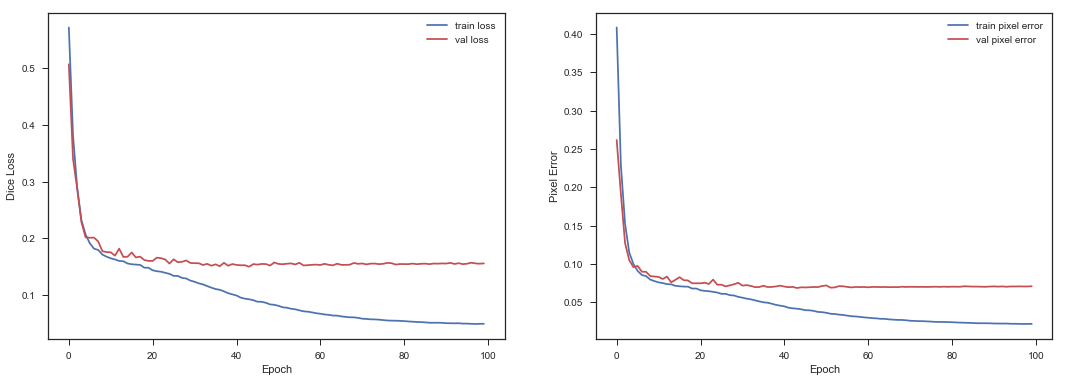

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Dice Loss')
ax[1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Pixel Error')
plt.show()

In [22]:
np.save(RESULT_PATH + 'history_Unet_fuse_v4.npy', results.history)

In [ ]:
model_u_net_fuse_v4.save_weights(WEIGHT_PATH + 'UNET_fuse_v4_weight.h5')
model_u_net_fuse_v4.save(MODEL_PATH + 'UNET_fuse_v4_model.h5')
model_json = model_u_net_fuse_v4.to_json()
with open(MODEL_PATH + 'UNET_fuse_v4_model.json', "w") as json_file:
    json_file.write(model_json)

In [8]:
model_u_net_fuse_v4 = u_net_fuse_v4(input_shape=(512, 512, 1))
model_u_net_fuse_v4.load_weights(WEIGHT_PATH + 'UNET_fuse_v4_weight.h5')

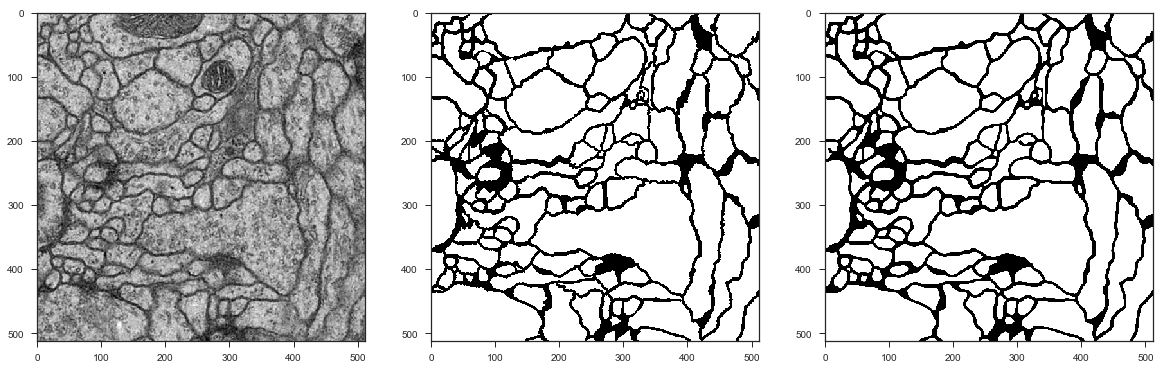

In [10]:
y_pred = model_u_net_fuse_v4.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

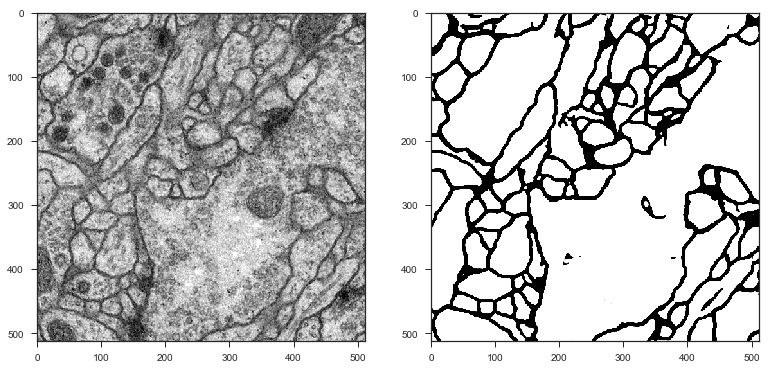

In [11]:
y_pred = model_u_net_fuse_v4.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [10]:
y_pred = model_u_net_fuse_v4.predict(X_test, batch_size=5)
result_fuse = y_pred[-1].astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

In [11]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v4_' + timestamp + '.tif', result_fuse, dtype=np.float32)

In [12]:
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v4_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

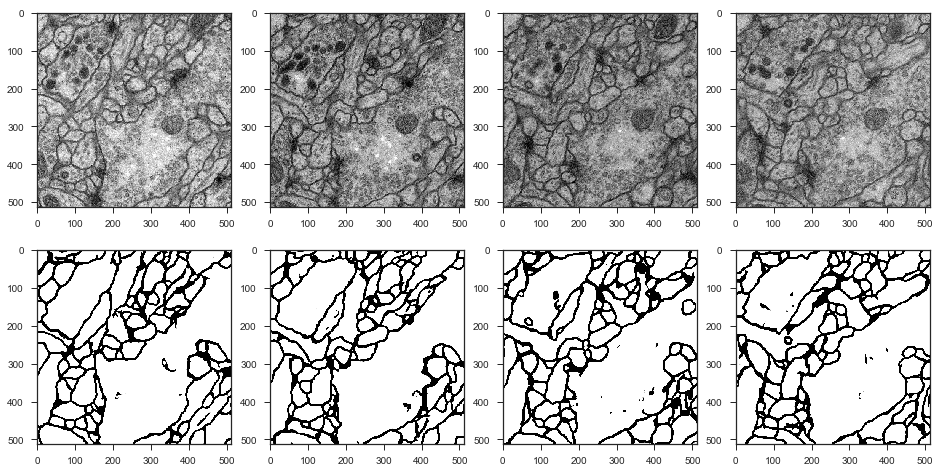

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()

Unet_Fuse_v3

In [9]:
model_unet_fuse_v5 = u_net_fuse_v5(input_shape=(512, 512, 1))
model_unet_fuse_v5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1664        lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [10]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v5', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v5.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_fuse_v5.fit(X_train, [y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=100, callbacks=callback_list, verbose=2)

Train on 297 samples, validate on 33 samples


Epoch 1/100


 - 57s - loss: -2.1119e+00 - o1_loss: -3.8753e-01 - o2_loss: -3.9741e-01 - o3_loss: -3.5618e-01 - o4_loss: -5.1475e-01 - ofuse_loss: -4.5600e-01 - ofuse_dice_coef: 0.4560 - ofuse_jaccard_coef: 0.2963 - ofuse_pixel_error: 0.3156 - val_loss: -2.4034e+00 - val_o1_loss: -4.0624e-01 - val_o2_loss: -4.7435e-01 - val_o3_loss: -4.3131e-01 - val_o4_loss: -5.7473e-01 - val_ofuse_loss: -5.1679e-01 - val_ofuse_dice_coef: 0.5168 - val_ofuse_jaccard_coef: 0.3473 - val_ofuse_pixel_error: 0.2202



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.22020, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 24s - loss: -2.9401e+00 - o1_loss: -5.1921e-01 - o2_loss: -5.9544e-01 - o3_loss: -5.1222e-01 - o4_loss: -6.6254e-01 - ofuse_loss: -6.5065e-01 - ofuse_dice_coef: 0.6506 - ofuse_jaccard_coef: 0.4815 - ofuse_pixel_error: 0.1595 - val_loss: -2.8155e+00 - val_o1_loss: -4.3344e-01 - val_o2_loss: -5.4581e-01 - val_o3_loss: -5.8506e-01 - val_o4_loss: -6.5089e-01 - val_ofuse_loss: -6.0031e-01 - val_ofuse_dice_coef: 0.6003 - val_ofuse_jaccard_coef: 0.4281 - val_ofuse_pixel_error: 0.1385



Epoch 00002: val_ofuse_pixel_error improved from 0.22020 to 0.13848, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/100


 - 23s - loss: -3.4338e+00 - o1_loss: -5.9311e-01 - o2_loss: -6.7596e-01 - o3_loss: -6.8215e-01 - o4_loss: -7.4435e-01 - ofuse_loss: -7.3823e-01 - ofuse_dice_coef: 0.7382 - ofuse_jaccard_coef: 0.5840 - ofuse_pixel_error: 0.1172 - val_loss: -3.4889e+00 - val_o1_loss: -5.9980e-01 - val_o2_loss: -6.9088e-01 - val_o3_loss: -7.1128e-01 - val_o4_loss: -7.4546e-01 - val_ofuse_loss: -7.4151e-01 - val_ofuse_dice_coef: 0.7415 - val_ofuse_jaccard_coef: 0.5884 - val_ofuse_pixel_error: 0.1115



Epoch 00003: val_ofuse_pixel_error improved from 0.13848 to 0.11146, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/100


 - 23s - loss: -3.6834e+00 - o1_loss: -6.2975e-01 - o2_loss: -7.2529e-01 - o3_loss: -7.5743e-01 - o4_loss: -7.8675e-01 - ofuse_loss: -7.8415e-01 - ofuse_dice_coef: 0.7841 - ofuse_jaccard_coef: 0.6438 - ofuse_pixel_error: 0.0973 - val_loss: -3.6428e+00 - val_o1_loss: -6.2464e-01 - val_o2_loss: -7.1820e-01 - val_o3_loss: -7.5739e-01 - val_o4_loss: -7.7393e-01 - val_ofuse_loss: -7.6864e-01 - val_ofuse_dice_coef: 0.7686 - val_ofuse_jaccard_coef: 0.6238 - val_ofuse_pixel_error: 0.0961



Epoch 00004: val_ofuse_pixel_error improved from 0.11146 to 0.09610, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/100


 - 23s - loss: -3.7842e+00 - o1_loss: -6.4442e-01 - o2_loss: -7.5161e-01 - o3_loss: -7.8482e-01 - o4_loss: -8.0215e-01 - ofuse_loss: -8.0121e-01 - ofuse_dice_coef: 0.8012 - ofuse_jaccard_coef: 0.6672 - ofuse_pixel_error: 0.0904 - val_loss: -3.7956e+00 - val_o1_loss: -6.5074e-01 - val_o2_loss: -7.5713e-01 - val_o3_loss: -7.8792e-01 - val_o4_loss: -8.0064e-01 - val_ofuse_loss: -7.9919e-01 - val_ofuse_dice_coef: 0.7992 - val_ofuse_jaccard_coef: 0.6646 - val_ofuse_pixel_error: 0.0891



Epoch 00005: val_ofuse_pixel_error improved from 0.09610 to 0.08911, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/100


 - 23s - loss: -3.8403e+00 - o1_loss: -6.5354e-01 - o2_loss: -7.6651e-01 - o3_loss: -8.0032e-01 - o4_loss: -8.1006e-01 - ofuse_loss: -8.0989e-01 - ofuse_dice_coef: 0.8099 - ofuse_jaccard_coef: 0.6793 - ofuse_pixel_error: 0.0870 - val_loss: -3.7263e+00 - val_o1_loss: -6.0517e-01 - val_o2_loss: -7.4855e-01 - val_o3_loss: -7.9060e-01 - val_o4_loss: -7.9189e-01 - val_ofuse_loss: -7.9009e-01 - val_ofuse_dice_coef: 0.7901 - val_ofuse_jaccard_coef: 0.6525 - val_ofuse_pixel_error: 0.0921



Epoch 00006: val_ofuse_pixel_error did not improve
Epoch 7/100


 - 23s - loss: -3.8846e+00 - o1_loss: -6.6075e-01 - o2_loss: -7.7793e-01 - o3_loss: -8.1118e-01 - o4_loss: -8.1738e-01 - ofuse_loss: -8.1737e-01 - ofuse_dice_coef: 0.8174 - ofuse_jaccard_coef: 0.6899 - ofuse_pixel_error: 0.0837 - val_loss: -3.8711e+00 - val_o1_loss: -6.6201e-01 - val_o2_loss: -7.7760e-01 - val_o3_loss: -8.0778e-01 - val_o4_loss: -8.1211e-01 - val_ofuse_loss: -8.1161e-01 - val_ofuse_dice_coef: 0.8116 - val_ofuse_jaccard_coef: 0.6826 - val_ofuse_pixel_error: 0.0868



Epoch 00007: val_ofuse_pixel_error improved from 0.08911 to 0.08676, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/100


 - 23s - loss: -3.9221e+00 - o1_loss: -6.6819e-01 - o2_loss: -7.8752e-01 - o3_loss: -8.1891e-01 - o4_loss: -8.2374e-01 - ofuse_loss: -8.2377e-01 - ofuse_dice_coef: 0.8238 - ofuse_jaccard_coef: 0.6992 - ofuse_pixel_error: 0.0809 - val_loss: -3.8622e+00 - val_o1_loss: -6.5584e-01 - val_o2_loss: -7.7328e-01 - val_o3_loss: -8.0993e-01 - val_o4_loss: -8.1194e-01 - val_ofuse_loss: -8.1119e-01 - val_ofuse_dice_coef: 0.8112 - val_ofuse_jaccard_coef: 0.6817 - val_ofuse_pixel_error: 0.0884



Epoch 00008: val_ofuse_pixel_error did not improve
Epoch 9/100


 - 23s - loss: -3.9241e+00 - o1_loss: -6.6855e-01 - o2_loss: -7.8856e-01 - o3_loss: -8.1987e-01 - o4_loss: -8.2349e-01 - ofuse_loss: -8.2358e-01 - ofuse_dice_coef: 0.8236 - ofuse_jaccard_coef: 0.6989 - ofuse_pixel_error: 0.0812 - val_loss: -3.8208e+00 - val_o1_loss: -6.5679e-01 - val_o2_loss: -7.7335e-01 - val_o3_loss: -7.9157e-01 - val_o4_loss: -7.9830e-01 - val_ofuse_loss: -8.0076e-01 - val_ofuse_dice_coef: 0.8008 - val_ofuse_jaccard_coef: 0.6673 - val_ofuse_pixel_error: 0.1015



Epoch 00009: val_ofuse_pixel_error did not improve
Epoch 10/100


 - 22s - loss: -3.9540e+00 - o1_loss: -6.7523e-01 - o2_loss: -7.9536e-01 - o3_loss: -8.2547e-01 - o4_loss: -8.2899e-01 - ofuse_loss: -8.2893e-01 - ofuse_dice_coef: 0.8289 - ofuse_jaccard_coef: 0.7066 - ofuse_pixel_error: 0.0786 - val_loss: -3.9094e+00 - val_o1_loss: -6.7369e-01 - val_o2_loss: -7.8601e-01 - val_o3_loss: -8.1612e-01 - val_o4_loss: -8.1614e-01 - val_ofuse_loss: -8.1744e-01 - val_ofuse_dice_coef: 0.8174 - val_ofuse_jaccard_coef: 0.6911 - val_ofuse_pixel_error: 0.0811



Epoch 00010: val_ofuse_pixel_error improved from 0.08676 to 0.08111, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/100


 - 22s - loss: -3.9763e+00 - o1_loss: -6.8014e-01 - o2_loss: -8.0016e-01 - o3_loss: -8.2999e-01 - o4_loss: -8.3303e-01 - ofuse_loss: -8.3301e-01 - ofuse_dice_coef: 0.8330 - ofuse_jaccard_coef: 0.7127 - ofuse_pixel_error: 0.0767 - val_loss: -3.9559e+00 - val_o1_loss: -6.7602e-01 - val_o2_loss: -7.9681e-01 - val_o3_loss: -8.2632e-01 - val_o4_loss: -8.2887e-01 - val_ofuse_loss: -8.2789e-01 - val_ofuse_dice_coef: 0.8279 - val_ofuse_jaccard_coef: 0.7057 - val_ofuse_pixel_error: 0.0807



Epoch 00011: val_ofuse_pixel_error improved from 0.08111 to 0.08067, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/100


 - 22s - loss: -3.9888e+00 - o1_loss: -6.8297e-01 - o2_loss: -8.0283e-01 - o3_loss: -8.3240e-01 - o4_loss: -8.3539e-01 - ofuse_loss: -8.3526e-01 - ofuse_dice_coef: 0.8353 - ofuse_jaccard_coef: 0.7162 - ofuse_pixel_error: 0.0757 - val_loss: -3.9303e+00 - val_o1_loss: -6.7203e-01 - val_o2_loss: -7.9088e-01 - val_o3_loss: -8.2091e-01 - val_o4_loss: -8.2259e-01 - val_ofuse_loss: -8.2390e-01 - val_ofuse_dice_coef: 0.8239 - val_ofuse_jaccard_coef: 0.6999 - val_ofuse_pixel_error: 0.0803



Epoch 00012: val_ofuse_pixel_error improved from 0.08067 to 0.08034, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 13/100


 - 23s - loss: -4.0042e+00 - o1_loss: -6.8599e-01 - o2_loss: -8.0653e-01 - o3_loss: -8.3523e-01 - o4_loss: -8.3831e-01 - ofuse_loss: -8.3816e-01 - ofuse_dice_coef: 0.8382 - ofuse_jaccard_coef: 0.7203 - ofuse_pixel_error: 0.0742 - val_loss: -3.9699e+00 - val_o1_loss: -6.8162e-01 - val_o2_loss: -8.0039e-01 - val_o3_loss: -8.2842e-01 - val_o4_loss: -8.3074e-01 - val_ofuse_loss: -8.2874e-01 - val_ofuse_dice_coef: 0.8287 - val_ofuse_jaccard_coef: 0.7069 - val_ofuse_pixel_error: 0.0807



Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/100


 - 22s - loss: -4.0131e+00 - o1_loss: -6.8802e-01 - o2_loss: -8.0815e-01 - o3_loss: -8.3707e-01 - o4_loss: -8.4006e-01 - ofuse_loss: -8.3979e-01 - ofuse_dice_coef: 0.8398 - ofuse_jaccard_coef: 0.7227 - ofuse_pixel_error: 0.0735 - val_loss: -3.9617e+00 - val_o1_loss: -6.7955e-01 - val_o2_loss: -7.9817e-01 - val_o3_loss: -8.2679e-01 - val_o4_loss: -8.2964e-01 - val_ofuse_loss: -8.2759e-01 - val_ofuse_dice_coef: 0.8276 - val_ofuse_jaccard_coef: 0.7052 - val_ofuse_pixel_error: 0.0815



Epoch 00014: val_ofuse_pixel_error did not improve
Epoch 15/100


 - 22s - loss: -4.0278e+00 - o1_loss: -6.9041e-01 - o2_loss: -8.1143e-01 - o3_loss: -8.4015e-01 - o4_loss: -8.4301e-01 - ofuse_loss: -8.4277e-01 - ofuse_dice_coef: 0.8428 - ofuse_jaccard_coef: 0.7271 - ofuse_pixel_error: 0.0722 - val_loss: -3.9765e+00 - val_o1_loss: -6.8577e-01 - val_o2_loss: -8.0266e-01 - val_o3_loss: -8.2837e-01 - val_o4_loss: -8.2992e-01 - val_ofuse_loss: -8.2980e-01 - val_ofuse_dice_coef: 0.8298 - val_ofuse_jaccard_coef: 0.7083 - val_ofuse_pixel_error: 0.0808



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/100


 - 22s - loss: -4.0376e+00 - o1_loss: -6.9264e-01 - o2_loss: -8.1356e-01 - o3_loss: -8.4192e-01 - o4_loss: -8.4491e-01 - ofuse_loss: -8.4458e-01 - ofuse_dice_coef: 0.8446 - ofuse_jaccard_coef: 0.7299 - ofuse_pixel_error: 0.0712 - val_loss: -3.9689e+00 - val_o1_loss: -6.8344e-01 - val_o2_loss: -8.0018e-01 - val_o3_loss: -8.2643e-01 - val_o4_loss: -8.2997e-01 - val_ofuse_loss: -8.2889e-01 - val_ofuse_dice_coef: 0.8289 - val_ofuse_jaccard_coef: 0.7072 - val_ofuse_pixel_error: 0.0801



Epoch 00016: val_ofuse_pixel_error improved from 0.08034 to 0.08008, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 17/100


 - 22s - loss: -4.0517e+00 - o1_loss: -6.9522e-01 - o2_loss: -8.1644e-01 - o3_loss: -8.4468e-01 - o4_loss: -8.4782e-01 - ofuse_loss: -8.4755e-01 - ofuse_dice_coef: 0.8475 - ofuse_jaccard_coef: 0.7343 - ofuse_pixel_error: 0.0698 - val_loss: -3.9913e+00 - val_o1_loss: -6.8817e-01 - val_o2_loss: -8.0259e-01 - val_o3_loss: -8.3214e-01 - val_o4_loss: -8.3435e-01 - val_ofuse_loss: -8.3406e-01 - val_ofuse_dice_coef: 0.8341 - val_ofuse_jaccard_coef: 0.7145 - val_ofuse_pixel_error: 0.0777



Epoch 00017: val_ofuse_pixel_error improved from 0.08008 to 0.07771, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 18/100


 - 22s - loss: -4.0562e+00 - o1_loss: -6.9710e-01 - o2_loss: -8.1729e-01 - o3_loss: -8.4544e-01 - o4_loss: -8.4838e-01 - ofuse_loss: -8.4803e-01 - ofuse_dice_coef: 0.8480 - ofuse_jaccard_coef: 0.7351 - ofuse_pixel_error: 0.0696 - val_loss: -3.9745e+00 - val_o1_loss: -6.8457e-01 - val_o2_loss: -8.0122e-01 - val_o3_loss: -8.2763e-01 - val_o4_loss: -8.3163e-01 - val_ofuse_loss: -8.2947e-01 - val_ofuse_dice_coef: 0.8295 - val_ofuse_jaccard_coef: 0.7080 - val_ofuse_pixel_error: 0.0801



Epoch 00018: val_ofuse_pixel_error did not improve
Epoch 19/100


 - 22s - loss: -4.0681e+00 - o1_loss: -6.9818e-01 - o2_loss: -8.2002e-01 - o3_loss: -8.4810e-01 - o4_loss: -8.5113e-01 - ofuse_loss: -8.5068e-01 - ofuse_dice_coef: 0.8507 - ofuse_jaccard_coef: 0.7389 - ofuse_pixel_error: 0.0684 - val_loss: -3.9845e+00 - val_o1_loss: -6.8621e-01 - val_o2_loss: -8.0196e-01 - val_o3_loss: -8.2996e-01 - val_o4_loss: -8.3388e-01 - val_ofuse_loss: -8.3253e-01 - val_ofuse_dice_coef: 0.8325 - val_ofuse_jaccard_coef: 0.7124 - val_ofuse_pixel_error: 0.0781



Epoch 00019: val_ofuse_pixel_error did not improve
Epoch 20/100


 - 22s - loss: -4.0792e+00 - o1_loss: -7.0075e-01 - o2_loss: -8.2224e-01 - o3_loss: -8.5020e-01 - o4_loss: -8.5316e-01 - ofuse_loss: -8.5288e-01 - ofuse_dice_coef: 0.8529 - ofuse_jaccard_coef: 0.7424 - ofuse_pixel_error: 0.0673 - val_loss: -3.9997e+00 - val_o1_loss: -6.9005e-01 - val_o2_loss: -8.0724e-01 - val_o3_loss: -8.3305e-01 - val_o4_loss: -8.3527e-01 - val_ofuse_loss: -8.3415e-01 - val_ofuse_dice_coef: 0.8341 - val_ofuse_jaccard_coef: 0.7150 - val_ofuse_pixel_error: 0.0773



Epoch 00020: val_ofuse_pixel_error improved from 0.07771 to 0.07728, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 21/100


 - 22s - loss: -4.0931e+00 - o1_loss: -7.0337e-01 - o2_loss: -8.2497e-01 - o3_loss: -8.5310e-01 - o4_loss: -8.5595e-01 - ofuse_loss: -8.5567e-01 - ofuse_dice_coef: 0.8557 - ofuse_jaccard_coef: 0.7465 - ofuse_pixel_error: 0.0659 - val_loss: -3.9945e+00 - val_o1_loss: -6.8828e-01 - val_o2_loss: -8.0551e-01 - val_o3_loss: -8.3160e-01 - val_o4_loss: -8.3552e-01 - val_ofuse_loss: -8.3357e-01 - val_ofuse_dice_coef: 0.8336 - val_ofuse_jaccard_coef: 0.7138 - val_ofuse_pixel_error: 0.0792



Epoch 00021: val_ofuse_pixel_error did not improve
Epoch 22/100


 - 22s - loss: -4.1030e+00 - o1_loss: -7.0492e-01 - o2_loss: -8.2692e-01 - o3_loss: -8.5524e-01 - o4_loss: -8.5804e-01 - ofuse_loss: -8.5785e-01 - ofuse_dice_coef: 0.8579 - ofuse_jaccard_coef: 0.7500 - ofuse_pixel_error: 0.0649 - val_loss: -4.0021e+00 - val_o1_loss: -6.8919e-01 - val_o2_loss: -8.0704e-01 - val_o3_loss: -8.3358e-01 - val_o4_loss: -8.3692e-01 - val_ofuse_loss: -8.3536e-01 - val_ofuse_dice_coef: 0.8354 - val_ofuse_jaccard_coef: 0.7164 - val_ofuse_pixel_error: 0.0784



Epoch 00022: val_ofuse_pixel_error did not improve
Epoch 23/100


 - 22s - loss: -4.1110e+00 - o1_loss: -7.0610e-01 - o2_loss: -8.2872e-01 - o3_loss: -8.5690e-01 - o4_loss: -8.5978e-01 - ofuse_loss: -8.5954e-01 - ofuse_dice_coef: 0.8595 - ofuse_jaccard_coef: 0.7527 - ofuse_pixel_error: 0.0641 - val_loss: -4.0190e+00 - val_o1_loss: -6.9168e-01 - val_o2_loss: -8.1166e-01 - val_o3_loss: -8.3639e-01 - val_o4_loss: -8.3933e-01 - val_ofuse_loss: -8.3997e-01 - val_ofuse_dice_coef: 0.8400 - val_ofuse_jaccard_coef: 0.7233 - val_ofuse_pixel_error: 0.0735



Epoch 00023: val_ofuse_pixel_error improved from 0.07728 to 0.07347, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 24/100


 - 22s - loss: -4.1210e+00 - o1_loss: -7.0781e-01 - o2_loss: -8.3082e-01 - o3_loss: -8.5902e-01 - o4_loss: -8.6171e-01 - ofuse_loss: -8.6164e-01 - ofuse_dice_coef: 0.8616 - ofuse_jaccard_coef: 0.7556 - ofuse_pixel_error: 0.0631 - val_loss: -3.9938e+00 - val_o1_loss: -6.8932e-01 - val_o2_loss: -8.0680e-01 - val_o3_loss: -8.3180e-01 - val_o4_loss: -8.3323e-01 - val_ofuse_loss: -8.3260e-01 - val_ofuse_dice_coef: 0.8326 - val_ofuse_jaccard_coef: 0.7126 - val_ofuse_pixel_error: 0.0782



Epoch 00024: val_ofuse_pixel_error did not improve
Epoch 25/100


 - 21s - loss: -4.1349e+00 - o1_loss: -7.0942e-01 - o2_loss: -8.3384e-01 - o3_loss: -8.6224e-01 - o4_loss: -8.6473e-01 - ofuse_loss: -8.6463e-01 - ofuse_dice_coef: 0.8646 - ofuse_jaccard_coef: 0.7603 - ofuse_pixel_error: 0.0617 - val_loss: -4.0246e+00 - val_o1_loss: -6.9230e-01 - val_o2_loss: -8.1216e-01 - val_o3_loss: -8.3773e-01 - val_o4_loss: -8.4118e-01 - val_ofuse_loss: -8.4124e-01 - val_ofuse_dice_coef: 0.8412 - val_ofuse_jaccard_coef: 0.7252 - val_ofuse_pixel_error: 0.0726



Epoch 00025: val_ofuse_pixel_error improved from 0.07347 to 0.07255, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 26/100


 - 22s - loss: -4.1344e+00 - o1_loss: -7.0958e-01 - o2_loss: -8.3358e-01 - o3_loss: -8.6205e-01 - o4_loss: -8.6462e-01 - ofuse_loss: -8.6453e-01 - ofuse_dice_coef: 0.8645 - ofuse_jaccard_coef: 0.7602 - ofuse_pixel_error: 0.0616 - val_loss: -4.0115e+00 - val_o1_loss: -6.9256e-01 - val_o2_loss: -8.1126e-01 - val_o3_loss: -8.3510e-01 - val_o4_loss: -8.3667e-01 - val_ofuse_loss: -8.3587e-01 - val_ofuse_dice_coef: 0.8359 - val_ofuse_jaccard_coef: 0.7173 - val_ofuse_pixel_error: 0.0784



Epoch 00026: val_ofuse_pixel_error did not improve
Epoch 27/100


 - 22s - loss: -4.1486e+00 - o1_loss: -7.1163e-01 - o2_loss: -8.3638e-01 - o3_loss: -8.6511e-01 - o4_loss: -8.6783e-01 - ofuse_loss: -8.6763e-01 - ofuse_dice_coef: 0.8676 - ofuse_jaccard_coef: 0.7651 - ofuse_pixel_error: 0.0604 - val_loss: -4.0418e+00 - val_o1_loss: -6.9513e-01 - val_o2_loss: -8.1470e-01 - val_o3_loss: -8.4256e-01 - val_o4_loss: -8.4515e-01 - val_ofuse_loss: -8.4428e-01 - val_ofuse_dice_coef: 0.8443 - val_ofuse_jaccard_coef: 0.7296 - val_ofuse_pixel_error: 0.0732



Epoch 00027: val_ofuse_pixel_error did not improve
Epoch 28/100


 - 22s - loss: -4.1636e+00 - o1_loss: -7.1389e-01 - o2_loss: -8.3967e-01 - o3_loss: -8.6834e-01 - o4_loss: -8.7082e-01 - ofuse_loss: -8.7089e-01 - ofuse_dice_coef: 0.8709 - ofuse_jaccard_coef: 0.7701 - ofuse_pixel_error: 0.0587 - val_loss: -4.0331e+00 - val_o1_loss: -6.9506e-01 - val_o2_loss: -8.1352e-01 - val_o3_loss: -8.3980e-01 - val_o4_loss: -8.4311e-01 - val_ofuse_loss: -8.4157e-01 - val_ofuse_dice_coef: 0.8416 - val_ofuse_jaccard_coef: 0.7258 - val_ofuse_pixel_error: 0.0744



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/100


 - 22s - loss: -4.1703e+00 - o1_loss: -7.1503e-01 - o2_loss: -8.4066e-01 - o3_loss: -8.6979e-01 - o4_loss: -8.7248e-01 - ofuse_loss: -8.7231e-01 - ofuse_dice_coef: 0.8723 - ofuse_jaccard_coef: 0.7724 - ofuse_pixel_error: 0.0581 - val_loss: -4.0392e+00 - val_o1_loss: -6.9577e-01 - val_o2_loss: -8.1523e-01 - val_o3_loss: -8.4125e-01 - val_o4_loss: -8.4420e-01 - val_ofuse_loss: -8.4277e-01 - val_ofuse_dice_coef: 0.8428 - val_ofuse_jaccard_coef: 0.7273 - val_ofuse_pixel_error: 0.0744



Epoch 00029: val_ofuse_pixel_error did not improve
Epoch 30/100


 - 22s - loss: -4.1749e+00 - o1_loss: -7.1542e-01 - o2_loss: -8.4175e-01 - o3_loss: -8.7093e-01 - o4_loss: -8.7334e-01 - ofuse_loss: -8.7341e-01 - ofuse_dice_coef: 0.8734 - ofuse_jaccard_coef: 0.7741 - ofuse_pixel_error: 0.0575 - val_loss: -4.0389e+00 - val_o1_loss: -6.9537e-01 - val_o2_loss: -8.1439e-01 - val_o3_loss: -8.4145e-01 - val_o4_loss: -8.4430e-01 - val_ofuse_loss: -8.4335e-01 - val_ofuse_dice_coef: 0.8434 - val_ofuse_jaccard_coef: 0.7283 - val_ofuse_pixel_error: 0.0735



Epoch 00030: val_ofuse_pixel_error did not improve
Epoch 31/100


 - 22s - loss: -4.1887e+00 - o1_loss: -7.1742e-01 - o2_loss: -8.4448e-01 - o3_loss: -8.7390e-01 - o4_loss: -8.7649e-01 - ofuse_loss: -8.7637e-01 - ofuse_dice_coef: 0.8764 - ofuse_jaccard_coef: 0.7788 - ofuse_pixel_error: 0.0563 - val_loss: -4.0200e+00 - val_o1_loss: -6.9330e-01 - val_o2_loss: -8.1202e-01 - val_o3_loss: -8.3707e-01 - val_o4_loss: -8.3831e-01 - val_ofuse_loss: -8.3926e-01 - val_ofuse_dice_coef: 0.8393 - val_ofuse_jaccard_coef: 0.7222 - val_ofuse_pixel_error: 0.0741



Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/100


 - 22s - loss: -4.2022e+00 - o1_loss: -7.1872e-01 - o2_loss: -8.4739e-01 - o3_loss: -8.7701e-01 - o4_loss: -8.7952e-01 - ofuse_loss: -8.7959e-01 - ofuse_dice_coef: 0.8796 - ofuse_jaccard_coef: 0.7840 - ofuse_pixel_error: 0.0546 - val_loss: -4.0253e+00 - val_o1_loss: -6.9492e-01 - val_o2_loss: -8.1321e-01 - val_o3_loss: -8.3768e-01 - val_o4_loss: -8.3970e-01 - val_ofuse_loss: -8.3975e-01 - val_ofuse_dice_coef: 0.8398 - val_ofuse_jaccard_coef: 0.7229 - val_ofuse_pixel_error: 0.0739



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/100


 - 22s - loss: -4.2155e+00 - o1_loss: -7.2061e-01 - o2_loss: -8.4994e-01 - o3_loss: -8.7994e-01 - o4_loss: -8.8253e-01 - ofuse_loss: -8.8251e-01 - ofuse_dice_coef: 0.8825 - ofuse_jaccard_coef: 0.7887 - ofuse_pixel_error: 0.0532 - val_loss: -4.0465e+00 - val_o1_loss: -6.9637e-01 - val_o2_loss: -8.1718e-01 - val_o3_loss: -8.4277e-01 - val_o4_loss: -8.4532e-01 - val_ofuse_loss: -8.4489e-01 - val_ofuse_dice_coef: 0.8449 - val_ofuse_jaccard_coef: 0.7306 - val_ofuse_pixel_error: 0.0724



Epoch 00033: val_ofuse_pixel_error improved from 0.07255 to 0.07238, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 34/100


 - 22s - loss: -4.2206e+00 - o1_loss: -7.2125e-01 - o2_loss: -8.5093e-01 - o3_loss: -8.8108e-01 - o4_loss: -8.8361e-01 - ofuse_loss: -8.8372e-01 - ofuse_dice_coef: 0.8837 - ofuse_jaccard_coef: 0.7906 - ofuse_pixel_error: 0.0527 - val_loss: -4.0446e+00 - val_o1_loss: -6.9544e-01 - val_o2_loss: -8.1667e-01 - val_o3_loss: -8.4236e-01 - val_o4_loss: -8.4499e-01 - val_ofuse_loss: -8.4511e-01 - val_ofuse_dice_coef: 0.8451 - val_ofuse_jaccard_coef: 0.7310 - val_ofuse_pixel_error: 0.0709



Epoch 00034: val_ofuse_pixel_error improved from 0.07238 to 0.07092, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 35/100


 - 23s - loss: -4.2353e+00 - o1_loss: -7.2278e-01 - o2_loss: -8.5361e-01 - o3_loss: -8.8452e-01 - o4_loss: -8.8718e-01 - ofuse_loss: -8.8721e-01 - ofuse_dice_coef: 0.8872 - ofuse_jaccard_coef: 0.7963 - ofuse_pixel_error: 0.0511 - val_loss: -4.0383e+00 - val_o1_loss: -6.9607e-01 - val_o2_loss: -8.1582e-01 - val_o3_loss: -8.4087e-01 - val_o4_loss: -8.4292e-01 - val_ofuse_loss: -8.4268e-01 - val_ofuse_dice_coef: 0.8427 - val_ofuse_jaccard_coef: 0.7273 - val_ofuse_pixel_error: 0.0727



Epoch 00035: val_ofuse_pixel_error did not improve
Epoch 36/100


 - 22s - loss: -4.2395e+00 - o1_loss: -7.2352e-01 - o2_loss: -8.5449e-01 - o3_loss: -8.8539e-01 - o4_loss: -8.8801e-01 - ofuse_loss: -8.8805e-01 - ofuse_dice_coef: 0.8881 - ofuse_jaccard_coef: 0.7975 - ofuse_pixel_error: 0.0507 - val_loss: -4.0241e+00 - val_o1_loss: -6.9544e-01 - val_o2_loss: -8.1347e-01 - val_o3_loss: -8.3660e-01 - val_o4_loss: -8.3832e-01 - val_ofuse_loss: -8.4025e-01 - val_ofuse_dice_coef: 0.8402 - val_ofuse_jaccard_coef: 0.7237 - val_ofuse_pixel_error: 0.0727



Epoch 00036: val_ofuse_pixel_error did not improve
Epoch 37/100


 - 22s - loss: -4.2500e+00 - o1_loss: -7.2416e-01 - o2_loss: -8.5660e-01 - o3_loss: -8.8800e-01 - o4_loss: -8.9057e-01 - ofuse_loss: -8.9069e-01 - ofuse_dice_coef: 0.8907 - ofuse_jaccard_coef: 0.8018 - ofuse_pixel_error: 0.0494 - val_loss: -4.0396e+00 - val_o1_loss: -6.9705e-01 - val_o2_loss: -8.1569e-01 - val_o3_loss: -8.4082e-01 - val_o4_loss: -8.4317e-01 - val_ofuse_loss: -8.4285e-01 - val_ofuse_dice_coef: 0.8428 - val_ofuse_jaccard_coef: 0.7277 - val_ofuse_pixel_error: 0.0728



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/100


 - 22s - loss: -4.2642e+00 - o1_loss: -7.2589e-01 - o2_loss: -8.5930e-01 - o3_loss: -8.9123e-01 - o4_loss: -8.9390e-01 - ofuse_loss: -8.9393e-01 - ofuse_dice_coef: 0.8939 - ofuse_jaccard_coef: 0.8071 - ofuse_pixel_error: 0.0479 - val_loss: -4.0472e+00 - val_o1_loss: -6.9613e-01 - val_o2_loss: -8.1816e-01 - val_o3_loss: -8.4281e-01 - val_o4_loss: -8.4486e-01 - val_ofuse_loss: -8.4527e-01 - val_ofuse_dice_coef: 0.8453 - val_ofuse_jaccard_coef: 0.7311 - val_ofuse_pixel_error: 0.0713



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/100


 - 22s - loss: -4.2634e+00 - o1_loss: -7.2594e-01 - o2_loss: -8.5916e-01 - o3_loss: -8.9099e-01 - o4_loss: -8.9359e-01 - ofuse_loss: -8.9376e-01 - ofuse_dice_coef: 0.8938 - ofuse_jaccard_coef: 0.8069 - ofuse_pixel_error: 0.0480 - val_loss: -4.0347e+00 - val_o1_loss: -6.9633e-01 - val_o2_loss: -8.1544e-01 - val_o3_loss: -8.3946e-01 - val_o4_loss: -8.4193e-01 - val_ofuse_loss: -8.4150e-01 - val_ofuse_dice_coef: 0.8415 - val_ofuse_jaccard_coef: 0.7252 - val_ofuse_pixel_error: 0.0752



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/100


 - 22s - loss: -4.2658e+00 - o1_loss: -7.2610e-01 - o2_loss: -8.5955e-01 - o3_loss: -8.9161e-01 - o4_loss: -8.9421e-01 - ofuse_loss: -8.9437e-01 - ofuse_dice_coef: 0.8944 - ofuse_jaccard_coef: 0.8080 - ofuse_pixel_error: 0.0477 - val_loss: -4.0342e+00 - val_o1_loss: -6.9824e-01 - val_o2_loss: -8.1585e-01 - val_o3_loss: -8.3897e-01 - val_o4_loss: -8.4013e-01 - val_ofuse_loss: -8.4106e-01 - val_ofuse_dice_coef: 0.8411 - val_ofuse_jaccard_coef: 0.7249 - val_ofuse_pixel_error: 0.0737



Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/100


 - 22s - loss: -4.2823e+00 - o1_loss: -7.2783e-01 - o2_loss: -8.6265e-01 - o3_loss: -8.9555e-01 - o4_loss: -8.9809e-01 - ofuse_loss: -8.9821e-01 - ofuse_dice_coef: 0.8982 - ofuse_jaccard_coef: 0.8142 - ofuse_pixel_error: 0.0459 - val_loss: -4.0517e+00 - val_o1_loss: -6.9883e-01 - val_o2_loss: -8.1903e-01 - val_o3_loss: -8.4311e-01 - val_o4_loss: -8.4498e-01 - val_ofuse_loss: -8.4576e-01 - val_ofuse_dice_coef: 0.8458 - val_ofuse_jaccard_coef: 0.7318 - val_ofuse_pixel_error: 0.0707



Epoch 00041: val_ofuse_pixel_error improved from 0.07092 to 0.07075, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 42/100


 - 22s - loss: -4.2927e+00 - o1_loss: -7.2889e-01 - o2_loss: -8.6455e-01 - o3_loss: -8.9792e-01 - o4_loss: -9.0066e-01 - ofuse_loss: -9.0067e-01 - ofuse_dice_coef: 0.9007 - ofuse_jaccard_coef: 0.8182 - ofuse_pixel_error: 0.0448 - val_loss: -4.0379e+00 - val_o1_loss: -6.9753e-01 - val_o2_loss: -8.1585e-01 - val_o3_loss: -8.4033e-01 - val_o4_loss: -8.4222e-01 - val_ofuse_loss: -8.4202e-01 - val_ofuse_dice_coef: 0.8420 - val_ofuse_jaccard_coef: 0.7262 - val_ofuse_pixel_error: 0.0736



Epoch 00042: val_ofuse_pixel_error did not improve
Epoch 43/100


 - 22s - loss: -4.2984e+00 - o1_loss: -7.2960e-01 - o2_loss: -8.6577e-01 - o3_loss: -8.9912e-01 - o4_loss: -9.0190e-01 - ofuse_loss: -9.0201e-01 - ofuse_dice_coef: 0.9020 - ofuse_jaccard_coef: 0.8205 - ofuse_pixel_error: 0.0441 - val_loss: -4.0316e+00 - val_o1_loss: -6.9786e-01 - val_o2_loss: -8.1469e-01 - val_o3_loss: -8.3813e-01 - val_o4_loss: -8.4010e-01 - val_ofuse_loss: -8.4083e-01 - val_ofuse_dice_coef: 0.8408 - val_ofuse_jaccard_coef: 0.7244 - val_ofuse_pixel_error: 0.0724



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/100


 - 22s - loss: -4.3031e+00 - o1_loss: -7.3009e-01 - o2_loss: -8.6655e-01 - o3_loss: -9.0029e-01 - o4_loss: -9.0297e-01 - ofuse_loss: -9.0315e-01 - ofuse_dice_coef: 0.9031 - ofuse_jaccard_coef: 0.8224 - ofuse_pixel_error: 0.0436 - val_loss: -4.0350e+00 - val_o1_loss: -6.9763e-01 - val_o2_loss: -8.1564e-01 - val_o3_loss: -8.3926e-01 - val_o4_loss: -8.4124e-01 - val_ofuse_loss: -8.4119e-01 - val_ofuse_dice_coef: 0.8412 - val_ofuse_jaccard_coef: 0.7249 - val_ofuse_pixel_error: 0.0734



Epoch 00044: val_ofuse_pixel_error did not improve
Epoch 45/100


 - 22s - loss: -4.3119e+00 - o1_loss: -7.3092e-01 - o2_loss: -8.6828e-01 - o3_loss: -9.0240e-01 - o4_loss: -9.0512e-01 - ofuse_loss: -9.0521e-01 - ofuse_dice_coef: 0.9052 - ofuse_jaccard_coef: 0.8259 - ofuse_pixel_error: 0.0426 - val_loss: -4.0349e+00 - val_o1_loss: -6.9672e-01 - val_o2_loss: -8.1509e-01 - val_o3_loss: -8.3986e-01 - val_o4_loss: -8.4142e-01 - val_ofuse_loss: -8.4177e-01 - val_ofuse_dice_coef: 0.8418 - val_ofuse_jaccard_coef: 0.7257 - val_ofuse_pixel_error: 0.0724



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/100


 - 22s - loss: -4.3167e+00 - o1_loss: -7.3144e-01 - o2_loss: -8.6923e-01 - o3_loss: -9.0348e-01 - o4_loss: -9.0622e-01 - ofuse_loss: -9.0633e-01 - ofuse_dice_coef: 0.9063 - ofuse_jaccard_coef: 0.8279 - ofuse_pixel_error: 0.0421 - val_loss: -4.0218e+00 - val_o1_loss: -6.9487e-01 - val_o2_loss: -8.1283e-01 - val_o3_loss: -8.3655e-01 - val_o4_loss: -8.3854e-01 - val_ofuse_loss: -8.3905e-01 - val_ofuse_dice_coef: 0.8390 - val_ofuse_jaccard_coef: 0.7219 - val_ofuse_pixel_error: 0.0729



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/100


 - 22s - loss: -4.3228e+00 - o1_loss: -7.3208e-01 - o2_loss: -8.7023e-01 - o3_loss: -9.0491e-01 - o4_loss: -9.0768e-01 - ofuse_loss: -9.0790e-01 - ofuse_dice_coef: 0.9079 - ofuse_jaccard_coef: 0.8304 - ofuse_pixel_error: 0.0414 - val_loss: -4.0368e+00 - val_o1_loss: -6.9750e-01 - val_o2_loss: -8.1534e-01 - val_o3_loss: -8.3962e-01 - val_o4_loss: -8.4199e-01 - val_ofuse_loss: -8.4234e-01 - val_ofuse_dice_coef: 0.8423 - val_ofuse_jaccard_coef: 0.7269 - val_ofuse_pixel_error: 0.0720



Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/100


 - 22s - loss: -4.3321e+00 - o1_loss: -7.3303e-01 - o2_loss: -8.7198e-01 - o3_loss: -9.0713e-01 - o4_loss: -9.0993e-01 - ofuse_loss: -9.1004e-01 - ofuse_dice_coef: 0.9100 - ofuse_jaccard_coef: 0.8340 - ofuse_pixel_error: 0.0404 - val_loss: -4.0393e+00 - val_o1_loss: -6.9746e-01 - val_o2_loss: -8.1769e-01 - val_o3_loss: -8.4011e-01 - val_o4_loss: -8.4179e-01 - val_ofuse_loss: -8.4227e-01 - val_ofuse_dice_coef: 0.8423 - val_ofuse_jaccard_coef: 0.7265 - val_ofuse_pixel_error: 0.0732



Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/100


 - 22s - loss: -4.3389e+00 - o1_loss: -7.3350e-01 - o2_loss: -8.7318e-01 - o3_loss: -9.0878e-01 - o4_loss: -9.1161e-01 - ofuse_loss: -9.1182e-01 - ofuse_dice_coef: 0.9118 - ofuse_jaccard_coef: 0.8370 - ofuse_pixel_error: 0.0396 - val_loss: -4.0452e+00 - val_o1_loss: -6.9965e-01 - val_o2_loss: -8.1708e-01 - val_o3_loss: -8.4148e-01 - val_o4_loss: -8.4335e-01 - val_ofuse_loss: -8.4362e-01 - val_ofuse_dice_coef: 0.8436 - val_ofuse_jaccard_coef: 0.7286 - val_ofuse_pixel_error: 0.0720



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/100


 - 22s - loss: -4.3439e+00 - o1_loss: -7.3427e-01 - o2_loss: -8.7406e-01 - o3_loss: -9.0991e-01 - o4_loss: -9.1281e-01 - ofuse_loss: -9.1290e-01 - ofuse_dice_coef: 0.9129 - ofuse_jaccard_coef: 0.8389 - ofuse_pixel_error: 0.0391 - val_loss: -4.0430e+00 - val_o1_loss: -6.9926e-01 - val_o2_loss: -8.1747e-01 - val_o3_loss: -8.4077e-01 - val_o4_loss: -8.4258e-01 - val_ofuse_loss: -8.4294e-01 - val_ofuse_dice_coef: 0.8429 - val_ofuse_jaccard_coef: 0.7274 - val_ofuse_pixel_error: 0.0731



Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/100


 - 22s - loss: -4.3409e+00 - o1_loss: -7.3423e-01 - o2_loss: -8.7373e-01 - o3_loss: -9.0910e-01 - o4_loss: -9.1184e-01 - ofuse_loss: -9.1205e-01 - ofuse_dice_coef: 0.9120 - ofuse_jaccard_coef: 0.8374 - ofuse_pixel_error: 0.0395 - val_loss: -4.0433e+00 - val_o1_loss: -6.9854e-01 - val_o2_loss: -8.1714e-01 - val_o3_loss: -8.4100e-01 - val_o4_loss: -8.4317e-01 - val_ofuse_loss: -8.4342e-01 - val_ofuse_dice_coef: 0.8434 - val_ofuse_jaccard_coef: 0.7283 - val_ofuse_pixel_error: 0.0723



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/100


 - 22s - loss: -4.3506e+00 - o1_loss: -7.3487e-01 - o2_loss: -8.7512e-01 - o3_loss: -9.1157e-01 - o4_loss: -9.1447e-01 - ofuse_loss: -9.1456e-01 - ofuse_dice_coef: 0.9146 - ofuse_jaccard_coef: 0.8417 - ofuse_pixel_error: 0.0384 - val_loss: -4.0297e+00 - val_o1_loss: -6.9773e-01 - val_o2_loss: -8.1390e-01 - val_o3_loss: -8.3804e-01 - val_o4_loss: -8.3964e-01 - val_ofuse_loss: -8.4036e-01 - val_ofuse_dice_coef: 0.8404 - val_ofuse_jaccard_coef: 0.7238 - val_ofuse_pixel_error: 0.0718



Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/100


 - 21s - loss: -4.3604e+00 - o1_loss: -7.3574e-01 - o2_loss: -8.7699e-01 - o3_loss: -9.1386e-01 - o4_loss: -9.1683e-01 - ofuse_loss: -9.1694e-01 - ofuse_dice_coef: 0.9169 - ofuse_jaccard_coef: 0.8458 - ofuse_pixel_error: 0.0373 - val_loss: -4.0257e+00 - val_o1_loss: -6.9786e-01 - val_o2_loss: -8.1346e-01 - val_o3_loss: -8.3670e-01 - val_o4_loss: -8.3840e-01 - val_ofuse_loss: -8.3923e-01 - val_ofuse_dice_coef: 0.8392 - val_ofuse_jaccard_coef: 0.7222 - val_ofuse_pixel_error: 0.0718



Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/100


 - 21s - loss: -4.3648e+00 - o1_loss: -7.3638e-01 - o2_loss: -8.7777e-01 - o3_loss: -9.1484e-01 - o4_loss: -9.1784e-01 - ofuse_loss: -9.1796e-01 - ofuse_dice_coef: 0.9180 - ofuse_jaccard_coef: 0.8475 - ofuse_pixel_error: 0.0368 - val_loss: -4.0369e+00 - val_o1_loss: -6.9891e-01 - val_o2_loss: -8.1395e-01 - val_o3_loss: -8.3977e-01 - val_o4_loss: -8.4197e-01 - val_ofuse_loss: -8.4226e-01 - val_ofuse_dice_coef: 0.8423 - val_ofuse_jaccard_coef: 0.7266 - val_ofuse_pixel_error: 0.0715



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/100


 - 21s - loss: -4.3653e+00 - o1_loss: -7.3664e-01 - o2_loss: -8.7789e-01 - o3_loss: -9.1492e-01 - o4_loss: -9.1782e-01 - ofuse_loss: -9.1801e-01 - ofuse_dice_coef: 0.9180 - ofuse_jaccard_coef: 0.8476 - ofuse_pixel_error: 0.0367 - val_loss: -4.0471e+00 - val_o1_loss: -6.9958e-01 - val_o2_loss: -8.1858e-01 - val_o3_loss: -8.4147e-01 - val_o4_loss: -8.4352e-01 - val_ofuse_loss: -8.4396e-01 - val_ofuse_dice_coef: 0.8440 - val_ofuse_jaccard_coef: 0.7290 - val_ofuse_pixel_error: 0.0720



Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/100


 - 21s - loss: -4.3675e+00 - o1_loss: -7.3681e-01 - o2_loss: -8.7823e-01 - o3_loss: -9.1546e-01 - o4_loss: -9.1841e-01 - ofuse_loss: -9.1856e-01 - ofuse_dice_coef: 0.9186 - ofuse_jaccard_coef: 0.8485 - ofuse_pixel_error: 0.0365 - val_loss: -4.0286e+00 - val_o1_loss: -6.9929e-01 - val_o2_loss: -8.1579e-01 - val_o3_loss: -8.3693e-01 - val_o4_loss: -8.3749e-01 - val_ofuse_loss: -8.3911e-01 - val_ofuse_dice_coef: 0.8391 - val_ofuse_jaccard_coef: 0.7218 - val_ofuse_pixel_error: 0.0722



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/100


 - 21s - loss: -4.3706e+00 - o1_loss: -7.3730e-01 - o2_loss: -8.7879e-01 - o3_loss: -9.1616e-01 - o4_loss: -9.1907e-01 - ofuse_loss: -9.1928e-01 - ofuse_dice_coef: 0.9193 - ofuse_jaccard_coef: 0.8499 - ofuse_pixel_error: 0.0362 - val_loss: -4.0440e+00 - val_o1_loss: -6.9944e-01 - val_o2_loss: -8.1773e-01 - val_o3_loss: -8.4095e-01 - val_o4_loss: -8.4288e-01 - val_ofuse_loss: -8.4304e-01 - val_ofuse_dice_coef: 0.8430 - val_ofuse_jaccard_coef: 0.7275 - val_ofuse_pixel_error: 0.0736



Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/100


 - 21s - loss: -4.3786e+00 - o1_loss: -7.3787e-01 - o2_loss: -8.8018e-01 - o3_loss: -9.1809e-01 - o4_loss: -9.2117e-01 - ofuse_loss: -9.2129e-01 - ofuse_dice_coef: 0.9213 - ofuse_jaccard_coef: 0.8532 - ofuse_pixel_error: 0.0352 - val_loss: -4.0325e+00 - val_o1_loss: -6.9939e-01 - val_o2_loss: -8.1576e-01 - val_o3_loss: -8.3788e-01 - val_o4_loss: -8.3929e-01 - val_ofuse_loss: -8.4017e-01 - val_ofuse_dice_coef: 0.8402 - val_ofuse_jaccard_coef: 0.7233 - val_ofuse_pixel_error: 0.0732



Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/100


 - 21s - loss: -4.3811e+00 - o1_loss: -7.3815e-01 - o2_loss: -8.8056e-01 - o3_loss: -9.1872e-01 - o4_loss: -9.2178e-01 - ofuse_loss: -9.2193e-01 - ofuse_dice_coef: 0.9219 - ofuse_jaccard_coef: 0.8543 - ofuse_pixel_error: 0.0350 - val_loss: -4.0312e+00 - val_o1_loss: -6.9880e-01 - val_o2_loss: -8.1413e-01 - val_o3_loss: -8.3789e-01 - val_o4_loss: -8.3992e-01 - val_ofuse_loss: -8.4046e-01 - val_ofuse_dice_coef: 0.8405 - val_ofuse_jaccard_coef: 0.7238 - val_ofuse_pixel_error: 0.0721



Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/100


 - 21s - loss: -4.3806e+00 - o1_loss: -7.3822e-01 - o2_loss: -8.8061e-01 - o3_loss: -9.1853e-01 - o4_loss: -9.2156e-01 - ofuse_loss: -9.2173e-01 - ofuse_dice_coef: 0.9217 - ofuse_jaccard_coef: 0.8540 - ofuse_pixel_error: 0.0350 - val_loss: -4.0320e+00 - val_o1_loss: -6.9829e-01 - val_o2_loss: -8.1438e-01 - val_o3_loss: -8.3823e-01 - val_o4_loss: -8.4018e-01 - val_ofuse_loss: -8.4089e-01 - val_ofuse_dice_coef: 0.8409 - val_ofuse_jaccard_coef: 0.7245 - val_ofuse_pixel_error: 0.0719



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/100


 - 21s - loss: -4.3861e+00 - o1_loss: -7.3891e-01 - o2_loss: -8.8131e-01 - o3_loss: -9.1991e-01 - o4_loss: -9.2288e-01 - ofuse_loss: -9.2314e-01 - ofuse_dice_coef: 0.9231 - ofuse_jaccard_coef: 0.8565 - ofuse_pixel_error: 0.0343 - val_loss: -4.0409e+00 - val_o1_loss: -6.9931e-01 - val_o2_loss: -8.1736e-01 - val_o3_loss: -8.4021e-01 - val_o4_loss: -8.4178e-01 - val_ofuse_loss: -8.4225e-01 - val_ofuse_dice_coef: 0.8422 - val_ofuse_jaccard_coef: 0.7265 - val_ofuse_pixel_error: 0.0729



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/100


 - 21s - loss: -4.3882e+00 - o1_loss: -7.3913e-01 - o2_loss: -8.8179e-01 - o3_loss: -9.2032e-01 - o4_loss: -9.2341e-01 - ofuse_loss: -9.2354e-01 - ofuse_dice_coef: 0.9235 - ofuse_jaccard_coef: 0.8571 - ofuse_pixel_error: 0.0342 - val_loss: -4.0405e+00 - val_o1_loss: -6.9982e-01 - val_o2_loss: -8.1764e-01 - val_o3_loss: -8.3944e-01 - val_o4_loss: -8.4141e-01 - val_ofuse_loss: -8.4220e-01 - val_ofuse_dice_coef: 0.8422 - val_ofuse_jaccard_coef: 0.7263 - val_ofuse_pixel_error: 0.0726



Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/100


 - 21s - loss: -4.3928e+00 - o1_loss: -7.3951e-01 - o2_loss: -8.8259e-01 - o3_loss: -9.2146e-01 - o4_loss: -9.2452e-01 - ofuse_loss: -9.2474e-01 - ofuse_dice_coef: 0.9247 - ofuse_jaccard_coef: 0.8592 - ofuse_pixel_error: 0.0336 - val_loss: -4.0415e+00 - val_o1_loss: -6.9901e-01 - val_o2_loss: -8.1727e-01 - val_o3_loss: -8.4028e-01 - val_o4_loss: -8.4231e-01 - val_ofuse_loss: -8.4262e-01 - val_ofuse_dice_coef: 0.8426 - val_ofuse_jaccard_coef: 0.7270 - val_ofuse_pixel_error: 0.0729



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/100


 - 21s - loss: -4.3982e+00 - o1_loss: -7.4002e-01 - o2_loss: -8.8348e-01 - o3_loss: -9.2278e-01 - o4_loss: -9.2592e-01 - ofuse_loss: -9.2605e-01 - ofuse_dice_coef: 0.9260 - ofuse_jaccard_coef: 0.8615 - ofuse_pixel_error: 0.0331 - val_loss: -4.0353e+00 - val_o1_loss: -6.9875e-01 - val_o2_loss: -8.1552e-01 - val_o3_loss: -8.3900e-01 - val_o4_loss: -8.4084e-01 - val_ofuse_loss: -8.4122e-01 - val_ofuse_dice_coef: 0.8412 - val_ofuse_jaccard_coef: 0.7250 - val_ofuse_pixel_error: 0.0729



Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/100


 - 22s - loss: -4.4000e+00 - o1_loss: -7.4025e-01 - o2_loss: -8.8383e-01 - o3_loss: -9.2311e-01 - o4_loss: -9.2631e-01 - ofuse_loss: -9.2647e-01 - ofuse_dice_coef: 0.9265 - ofuse_jaccard_coef: 0.8623 - ofuse_pixel_error: 0.0329 - val_loss: -4.0339e+00 - val_o1_loss: -6.9868e-01 - val_o2_loss: -8.1572e-01 - val_o3_loss: -8.3859e-01 - val_o4_loss: -8.4002e-01 - val_ofuse_loss: -8.4087e-01 - val_ofuse_dice_coef: 0.8409 - val_ofuse_jaccard_coef: 0.7245 - val_ofuse_pixel_error: 0.0722



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/100


 - 21s - loss: -4.4015e+00 - o1_loss: -7.4044e-01 - o2_loss: -8.8404e-01 - o3_loss: -9.2347e-01 - o4_loss: -9.2672e-01 - ofuse_loss: -9.2685e-01 - ofuse_dice_coef: 0.9268 - ofuse_jaccard_coef: 0.8630 - ofuse_pixel_error: 0.0327 - val_loss: -4.0280e+00 - val_o1_loss: -6.9920e-01 - val_o2_loss: -8.1465e-01 - val_o3_loss: -8.3663e-01 - val_o4_loss: -8.3828e-01 - val_ofuse_loss: -8.3921e-01 - val_ofuse_dice_coef: 0.8392 - val_ofuse_jaccard_coef: 0.7219 - val_ofuse_pixel_error: 0.0726



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/100


 - 21s - loss: -4.4005e+00 - o1_loss: -7.4041e-01 - o2_loss: -8.8397e-01 - o3_loss: -9.2318e-01 - o4_loss: -9.2639e-01 - ofuse_loss: -9.2656e-01 - ofuse_dice_coef: 0.9266 - ofuse_jaccard_coef: 0.8624 - ofuse_pixel_error: 0.0328 - val_loss: -4.0313e+00 - val_o1_loss: -6.9920e-01 - val_o2_loss: -8.1499e-01 - val_o3_loss: -8.3740e-01 - val_o4_loss: -8.3945e-01 - val_ofuse_loss: -8.4022e-01 - val_ofuse_dice_coef: 0.8402 - val_ofuse_jaccard_coef: 0.7234 - val_ofuse_pixel_error: 0.0723



Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.000209715217352.

Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/100


 - 22s - loss: -4.4040e+00 - o1_loss: -7.4069e-01 - o2_loss: -8.8448e-01 - o3_loss: -9.2409e-01 - o4_loss: -9.2726e-01 - ofuse_loss: -9.2747e-01 - ofuse_dice_coef: 0.9275 - ofuse_jaccard_coef: 0.8640 - ofuse_pixel_error: 0.0324 - val_loss: -4.0360e+00 - val_o1_loss: -6.9950e-01 - val_o2_loss: -8.1636e-01 - val_o3_loss: -8.3868e-01 - val_o4_loss: -8.4039e-01 - val_ofuse_loss: -8.4108e-01 - val_ofuse_dice_coef: 0.8411 - val_ofuse_jaccard_coef: 0.7247 - val_ofuse_pixel_error: 0.0726



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/100


 - 22s - loss: -4.4091e+00 - o1_loss: -7.4126e-01 - o2_loss: -8.8528e-01 - o3_loss: -9.2529e-01 - o4_loss: -9.2859e-01 - ofuse_loss: -9.2872e-01 - ofuse_dice_coef: 0.9287 - ofuse_jaccard_coef: 0.8662 - ofuse_pixel_error: 0.0319 - val_loss: -4.0314e+00 - val_o1_loss: -6.9850e-01 - val_o2_loss: -8.1559e-01 - val_o3_loss: -8.3767e-01 - val_o4_loss: -8.3945e-01 - val_ofuse_loss: -8.4017e-01 - val_ofuse_dice_coef: 0.8402 - val_ofuse_jaccard_coef: 0.7234 - val_ofuse_pixel_error: 0.0728



Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/100


 - 22s - loss: -4.4086e+00 - o1_loss: -7.4122e-01 - o2_loss: -8.8528e-01 - o3_loss: -9.2513e-01 - o4_loss: -9.2838e-01 - ofuse_loss: -9.2858e-01 - ofuse_dice_coef: 0.9286 - ofuse_jaccard_coef: 0.8659 - ofuse_pixel_error: 0.0319 - val_loss: -4.0337e+00 - val_o1_loss: -6.9984e-01 - val_o2_loss: -8.1650e-01 - val_o3_loss: -8.3759e-01 - val_o4_loss: -8.3934e-01 - val_ofuse_loss: -8.4046e-01 - val_ofuse_dice_coef: 0.8405 - val_ofuse_jaccard_coef: 0.7238 - val_ofuse_pixel_error: 0.0723



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/100


 - 22s - loss: -4.4113e+00 - o1_loss: -7.4145e-01 - o2_loss: -8.8570e-01 - o3_loss: -9.2581e-01 - o4_loss: -9.2906e-01 - ofuse_loss: -9.2924e-01 - ofuse_dice_coef: 0.9292 - ofuse_jaccard_coef: 0.8671 - ofuse_pixel_error: 0.0316 - val_loss: -4.0359e+00 - val_o1_loss: -6.9933e-01 - val_o2_loss: -8.1593e-01 - val_o3_loss: -8.3892e-01 - val_o4_loss: -8.4059e-01 - val_ofuse_loss: -8.4110e-01 - val_ofuse_dice_coef: 0.8411 - val_ofuse_jaccard_coef: 0.7247 - val_ofuse_pixel_error: 0.0727



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/100


 - 22s - loss: -4.4134e+00 - o1_loss: -7.4179e-01 - o2_loss: -8.8605e-01 - o3_loss: -9.2626e-01 - o4_loss: -9.2960e-01 - ofuse_loss: -9.2972e-01 - ofuse_dice_coef: 0.9297 - ofuse_jaccard_coef: 0.8678 - ofuse_pixel_error: 0.0314 - val_loss: -4.0308e+00 - val_o1_loss: -6.9862e-01 - val_o2_loss: -8.1619e-01 - val_o3_loss: -8.3743e-01 - val_o4_loss: -8.3873e-01 - val_ofuse_loss: -8.3981e-01 - val_ofuse_dice_coef: 0.8398 - val_ofuse_jaccard_coef: 0.7228 - val_ofuse_pixel_error: 0.0727



Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.000167772173882.

Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/100


 - 22s - loss: -4.4138e+00 - o1_loss: -7.4179e-01 - o2_loss: -8.8616e-01 - o3_loss: -9.2635e-01 - o4_loss: -9.2966e-01 - ofuse_loss: -9.2989e-01 - ofuse_dice_coef: 0.9299 - ofuse_jaccard_coef: 0.8683 - ofuse_pixel_error: 0.0313 - val_loss: -4.0362e+00 - val_o1_loss: -6.9932e-01 - val_o2_loss: -8.1618e-01 - val_o3_loss: -8.3879e-01 - val_o4_loss: -8.4070e-01 - val_ofuse_loss: -8.4122e-01 - val_ofuse_dice_coef: 0.8412 - val_ofuse_jaccard_coef: 0.7249 - val_ofuse_pixel_error: 0.0726



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/100


 - 21s - loss: -4.4181e+00 - o1_loss: -7.4206e-01 - o2_loss: -8.8675e-01 - o3_loss: -9.2744e-01 - o4_loss: -9.3082e-01 - ofuse_loss: -9.3101e-01 - ofuse_dice_coef: 0.9310 - ofuse_jaccard_coef: 0.8701 - ofuse_pixel_error: 0.0308 - val_loss: -4.0343e+00 - val_o1_loss: -6.9934e-01 - val_o2_loss: -8.1608e-01 - val_o3_loss: -8.3822e-01 - val_o4_loss: -8.4004e-01 - val_ofuse_loss: -8.4065e-01 - val_ofuse_dice_coef: 0.8406 - val_ofuse_jaccard_coef: 0.7241 - val_ofuse_pixel_error: 0.0729



Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/100


 - 21s - loss: -4.4169e+00 - o1_loss: -7.4213e-01 - o2_loss: -8.8657e-01 - o3_loss: -9.2713e-01 - o4_loss: -9.3048e-01 - ofuse_loss: -9.3063e-01 - ofuse_dice_coef: 0.9306 - ofuse_jaccard_coef: 0.8695 - ofuse_pixel_error: 0.0310 - val_loss: -4.0265e+00 - val_o1_loss: -6.9894e-01 - val_o2_loss: -8.1578e-01 - val_o3_loss: -8.3590e-01 - val_o4_loss: -8.3722e-01 - val_ofuse_loss: -8.3861e-01 - val_ofuse_dice_coef: 0.8386 - val_ofuse_jaccard_coef: 0.7211 - val_ofuse_pixel_error: 0.0727



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/100


 - 22s - loss: -4.4200e+00 - o1_loss: -7.4245e-01 - o2_loss: -8.8707e-01 - o3_loss: -9.2786e-01 - o4_loss: -9.3125e-01 - ofuse_loss: -9.3142e-01 - ofuse_dice_coef: 0.9314 - ofuse_jaccard_coef: 0.8708 - ofuse_pixel_error: 0.0306 - val_loss: -4.0280e+00 - val_o1_loss: -6.9880e-01 - val_o2_loss: -8.1524e-01 - val_o3_loss: -8.3684e-01 - val_o4_loss: -8.3809e-01 - val_ofuse_loss: -8.3906e-01 - val_ofuse_dice_coef: 0.8391 - val_ofuse_jaccard_coef: 0.7217 - val_ofuse_pixel_error: 0.0728



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/100


 - 22s - loss: -4.4196e+00 - o1_loss: -7.4234e-01 - o2_loss: -8.8705e-01 - o3_loss: -9.2774e-01 - o4_loss: -9.3113e-01 - ofuse_loss: -9.3133e-01 - ofuse_dice_coef: 0.9313 - ofuse_jaccard_coef: 0.8707 - ofuse_pixel_error: 0.0306 - val_loss: -4.0371e+00 - val_o1_loss: -6.9914e-01 - val_o2_loss: -8.1660e-01 - val_o3_loss: -8.3914e-01 - val_o4_loss: -8.4095e-01 - val_ofuse_loss: -8.4128e-01 - val_ofuse_dice_coef: 0.8413 - val_ofuse_jaccard_coef: 0.7250 - val_ofuse_pixel_error: 0.0733



Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.000134217739105.

Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/100


 - 22s - loss: -4.4229e+00 - o1_loss: -7.4268e-01 - o2_loss: -8.8760e-01 - o3_loss: -9.2855e-01 - o4_loss: -9.3195e-01 - ofuse_loss: -9.3213e-01 - ofuse_dice_coef: 0.9321 - ofuse_jaccard_coef: 0.8721 - ofuse_pixel_error: 0.0303 - val_loss: -4.0370e+00 - val_o1_loss: -6.9992e-01 - val_o2_loss: -8.1728e-01 - val_o3_loss: -8.3861e-01 - val_o4_loss: -8.4014e-01 - val_ofuse_loss: -8.4102e-01 - val_ofuse_dice_coef: 0.8410 - val_ofuse_jaccard_coef: 0.7246 - val_ofuse_pixel_error: 0.0729



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/100


 - 22s - loss: -4.4228e+00 - o1_loss: -7.4275e-01 - o2_loss: -8.8757e-01 - o3_loss: -9.2850e-01 - o4_loss: -9.3192e-01 - ofuse_loss: -9.3207e-01 - ofuse_dice_coef: 0.9321 - ofuse_jaccard_coef: 0.8720 - ofuse_pixel_error: 0.0303 - val_loss: -4.0355e+00 - val_o1_loss: -6.9966e-01 - val_o2_loss: -8.1680e-01 - val_o3_loss: -8.3848e-01 - val_o4_loss: -8.3992e-01 - val_ofuse_loss: -8.4061e-01 - val_ofuse_dice_coef: 0.8406 - val_ofuse_jaccard_coef: 0.7240 - val_ofuse_pixel_error: 0.0730



Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/100


 - 22s - loss: -4.4250e+00 - o1_loss: -7.4300e-01 - o2_loss: -8.8792e-01 - o3_loss: -9.2899e-01 - o4_loss: -9.3244e-01 - ofuse_loss: -9.3261e-01 - ofuse_dice_coef: 0.9326 - ofuse_jaccard_coef: 0.8731 - ofuse_pixel_error: 0.0301 - val_loss: -4.0265e+00 - val_o1_loss: -6.9915e-01 - val_o2_loss: -8.1525e-01 - val_o3_loss: -8.3622e-01 - val_o4_loss: -8.3736e-01 - val_ofuse_loss: -8.3851e-01 - val_ofuse_dice_coef: 0.8385 - val_ofuse_jaccard_coef: 0.7209 - val_ofuse_pixel_error: 0.0729



Epoch 00080: val_ofuse_pixel_error did not improve
Epoch 81/100


 - 22s - loss: -4.4258e+00 - o1_loss: -7.4297e-01 - o2_loss: -8.8807e-01 - o3_loss: -9.2924e-01 - o4_loss: -9.3265e-01 - ofuse_loss: -9.3287e-01 - ofuse_dice_coef: 0.9329 - ofuse_jaccard_coef: 0.8735 - ofuse_pixel_error: 0.0299 - val_loss: -4.0207e+00 - val_o1_loss: -6.9893e-01 - val_o2_loss: -8.1361e-01 - val_o3_loss: -8.3463e-01 - val_o4_loss: -8.3627e-01 - val_ofuse_loss: -8.3727e-01 - val_ofuse_dice_coef: 0.8373 - val_ofuse_jaccard_coef: 0.7192 - val_ofuse_pixel_error: 0.0730



Epoch 00081: val_ofuse_pixel_error did not improve
Epoch 82/100


 - 22s - loss: -4.4268e+00 - o1_loss: -7.4316e-01 - o2_loss: -8.8824e-01 - o3_loss: -9.2945e-01 - o4_loss: -9.3286e-01 - ofuse_loss: -9.3310e-01 - ofuse_dice_coef: 0.9331 - ofuse_jaccard_coef: 0.8738 - ofuse_pixel_error: 0.0298 - val_loss: -4.0371e+00 - val_o1_loss: -6.9928e-01 - val_o2_loss: -8.1671e-01 - val_o3_loss: -8.3908e-01 - val_o4_loss: -8.4080e-01 - val_ofuse_loss: -8.4121e-01 - val_ofuse_dice_coef: 0.8412 - val_ofuse_jaccard_coef: 0.7248 - val_ofuse_pixel_error: 0.0736



Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.000107374193612.

Epoch 00082: val_ofuse_pixel_error did not improve
Epoch 83/100


 - 22s - loss: -4.4281e+00 - o1_loss: -7.4330e-01 - o2_loss: -8.8851e-01 - o3_loss: -9.2975e-01 - o4_loss: -9.3317e-01 - ofuse_loss: -9.3336e-01 - ofuse_dice_coef: 0.9334 - ofuse_jaccard_coef: 0.8743 - ofuse_pixel_error: 0.0297 - val_loss: -4.0367e+00 - val_o1_loss: -6.9932e-01 - val_o2_loss: -8.1672e-01 - val_o3_loss: -8.3896e-01 - val_o4_loss: -8.4063e-01 - val_ofuse_loss: -8.4107e-01 - val_ofuse_dice_coef: 0.8411 - val_ofuse_jaccard_coef: 0.7247 - val_ofuse_pixel_error: 0.0733



Epoch 00083: val_ofuse_pixel_error did not improve
Epoch 84/100


 - 22s - loss: -4.4293e+00 - o1_loss: -7.4356e-01 - o2_loss: -8.8864e-01 - o3_loss: -9.3001e-01 - o4_loss: -9.3345e-01 - ofuse_loss: -9.3367e-01 - ofuse_dice_coef: 0.9337 - ofuse_jaccard_coef: 0.8748 - ofuse_pixel_error: 0.0296 - val_loss: -4.0344e+00 - val_o1_loss: -6.9884e-01 - val_o2_loss: -8.1635e-01 - val_o3_loss: -8.3836e-01 - val_o4_loss: -8.4015e-01 - val_ofuse_loss: -8.4066e-01 - val_ofuse_dice_coef: 0.8407 - val_ofuse_jaccard_coef: 0.7240 - val_ofuse_pixel_error: 0.0734



Epoch 00084: val_ofuse_pixel_error did not improve
Epoch 85/100


 - 22s - loss: -4.4305e+00 - o1_loss: -7.4363e-01 - o2_loss: -8.8884e-01 - o3_loss: -9.3031e-01 - o4_loss: -9.3379e-01 - ofuse_loss: -9.3395e-01 - ofuse_dice_coef: 0.9339 - ofuse_jaccard_coef: 0.8754 - ofuse_pixel_error: 0.0295 - val_loss: -4.0316e+00 - val_o1_loss: -6.9914e-01 - val_o2_loss: -8.1621e-01 - val_o3_loss: -8.3750e-01 - val_o4_loss: -8.3900e-01 - val_ofuse_loss: -8.3973e-01 - val_ofuse_dice_coef: 0.8397 - val_ofuse_jaccard_coef: 0.7227 - val_ofuse_pixel_error: 0.0733



Epoch 00085: val_ofuse_pixel_error did not improve
Epoch 86/100


 - 21s - loss: -4.4314e+00 - o1_loss: -7.4364e-01 - o2_loss: -8.8900e-01 - o3_loss: -9.3055e-01 - o4_loss: -9.3402e-01 - ofuse_loss: -9.3418e-01 - ofuse_dice_coef: 0.9342 - ofuse_jaccard_coef: 0.8758 - ofuse_pixel_error: 0.0294 - val_loss: -4.0310e+00 - val_o1_loss: -6.9878e-01 - val_o2_loss: -8.1591e-01 - val_o3_loss: -8.3732e-01 - val_o4_loss: -8.3914e-01 - val_ofuse_loss: -8.3987e-01 - val_ofuse_dice_coef: 0.8399 - val_ofuse_jaccard_coef: 0.7229 - val_ofuse_pixel_error: 0.0731



Epoch 00086: val_ofuse_pixel_error did not improve
Epoch 87/100


 - 22s - loss: -4.4333e+00 - o1_loss: -7.4386e-01 - o2_loss: -8.8924e-01 - o3_loss: -9.3097e-01 - o4_loss: -9.3451e-01 - ofuse_loss: -9.3469e-01 - ofuse_dice_coef: 0.9347 - ofuse_jaccard_coef: 0.8766 - ofuse_pixel_error: 0.0291 - val_loss: -4.0285e+00 - val_o1_loss: -6.9910e-01 - val_o2_loss: -8.1550e-01 - val_o3_loss: -8.3672e-01 - val_o4_loss: -8.3817e-01 - val_ofuse_loss: -8.3897e-01 - val_ofuse_dice_coef: 0.8390 - val_ofuse_jaccard_coef: 0.7216 - val_ofuse_pixel_error: 0.0731



Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00087: val_ofuse_pixel_error did not improve
Epoch 88/100


 - 22s - loss: -4.4317e+00 - o1_loss: -7.4381e-01 - o2_loss: -8.8905e-01 - o3_loss: -9.3057e-01 - o4_loss: -9.3404e-01 - ofuse_loss: -9.3424e-01 - ofuse_dice_coef: 0.9342 - ofuse_jaccard_coef: 0.8759 - ofuse_pixel_error: 0.0293 - val_loss: -4.0264e+00 - val_o1_loss: -6.9900e-01 - val_o2_loss: -8.1525e-01 - val_o3_loss: -8.3609e-01 - val_o4_loss: -8.3757e-01 - val_ofuse_loss: -8.3844e-01 - val_ofuse_dice_coef: 0.8384 - val_ofuse_jaccard_coef: 0.7208 - val_ofuse_pixel_error: 0.0735



Epoch 00088: val_ofuse_pixel_error did not improve
Epoch 89/100


 - 22s - loss: -4.4339e+00 - o1_loss: -7.4393e-01 - o2_loss: -8.8937e-01 - o3_loss: -9.3110e-01 - o4_loss: -9.3467e-01 - ofuse_loss: -9.3481e-01 - ofuse_dice_coef: 0.9348 - ofuse_jaccard_coef: 0.8769 - ofuse_pixel_error: 0.0291 - val_loss: -4.0276e+00 - val_o1_loss: -6.9904e-01 - val_o2_loss: -8.1478e-01 - val_o3_loss: -8.3655e-01 - val_o4_loss: -8.3830e-01 - val_ofuse_loss: -8.3897e-01 - val_ofuse_dice_coef: 0.8390 - val_ofuse_jaccard_coef: 0.7216 - val_ofuse_pixel_error: 0.0733



Epoch 00089: val_ofuse_pixel_error did not improve
Epoch 90/100


 - 22s - loss: -4.4346e+00 - o1_loss: -7.4401e-01 - o2_loss: -8.8940e-01 - o3_loss: -9.3131e-01 - o4_loss: -9.3488e-01 - ofuse_loss: -9.3503e-01 - ofuse_dice_coef: 0.9350 - ofuse_jaccard_coef: 0.8773 - ofuse_pixel_error: 0.0290 - val_loss: -4.0253e+00 - val_o1_loss: -6.9905e-01 - val_o2_loss: -8.1502e-01 - val_o3_loss: -8.3575e-01 - val_o4_loss: -8.3721e-01 - val_ofuse_loss: -8.3824e-01 - val_ofuse_dice_coef: 0.8382 - val_ofuse_jaccard_coef: 0.7205 - val_ofuse_pixel_error: 0.0732



Epoch 00090: val_ofuse_pixel_error did not improve
Epoch 91/100


 - 21s - loss: -4.4356e+00 - o1_loss: -7.4426e-01 - o2_loss: -8.8962e-01 - o3_loss: -9.3150e-01 - o4_loss: -9.3502e-01 - ofuse_loss: -9.3523e-01 - ofuse_dice_coef: 0.9352 - ofuse_jaccard_coef: 0.8776 - ofuse_pixel_error: 0.0289 - val_loss: -4.0306e+00 - val_o1_loss: -6.9950e-01 - val_o2_loss: -8.1588e-01 - val_o3_loss: -8.3713e-01 - val_o4_loss: -8.3860e-01 - val_ofuse_loss: -8.3951e-01 - val_ofuse_dice_coef: 0.8395 - val_ofuse_jaccard_coef: 0.7223 - val_ofuse_pixel_error: 0.0731



Epoch 00091: val_ofuse_pixel_error did not improve
Epoch 92/100


 - 22s - loss: -4.4365e+00 - o1_loss: -7.4422e-01 - o2_loss: -8.8973e-01 - o3_loss: -9.3176e-01 - o4_loss: -9.3534e-01 - ofuse_loss: -9.3549e-01 - ofuse_dice_coef: 0.9355 - ofuse_jaccard_coef: 0.8781 - ofuse_pixel_error: 0.0288 - val_loss: -4.0188e+00 - val_o1_loss: -6.9849e-01 - val_o2_loss: -8.1415e-01 - val_o3_loss: -8.3404e-01 - val_o4_loss: -8.3552e-01 - val_ofuse_loss: -8.3657e-01 - val_ofuse_dice_coef: 0.8366 - val_ofuse_jaccard_coef: 0.7181 - val_ofuse_pixel_error: 0.0733



Epoch 00092: val_ofuse_pixel_error did not improve
Epoch 93/100


 - 22s - loss: -4.4364e+00 - o1_loss: -7.4431e-01 - o2_loss: -8.8975e-01 - o3_loss: -9.3168e-01 - o4_loss: -9.3521e-01 - ofuse_loss: -9.3543e-01 - ofuse_dice_coef: 0.9354 - ofuse_jaccard_coef: 0.8780 - ofuse_pixel_error: 0.0288 - val_loss: -4.0315e+00 - val_o1_loss: -6.9914e-01 - val_o2_loss: -8.1606e-01 - val_o3_loss: -8.3752e-01 - val_o4_loss: -8.3905e-01 - val_ofuse_loss: -8.3976e-01 - val_ofuse_dice_coef: 0.8398 - val_ofuse_jaccard_coef: 0.7227 - val_ofuse_pixel_error: 0.0735



Epoch 00093: val_ofuse_pixel_error did not improve
Epoch 94/100


 - 22s - loss: -4.4365e+00 - o1_loss: -7.4428e-01 - o2_loss: -8.8979e-01 - o3_loss: -9.3171e-01 - o4_loss: -9.3524e-01 - ofuse_loss: -9.3544e-01 - ofuse_dice_coef: 0.9354 - ofuse_jaccard_coef: 0.8780 - ofuse_pixel_error: 0.0288 - val_loss: -4.0303e+00 - val_o1_loss: -6.9865e-01 - val_o2_loss: -8.1549e-01 - val_o3_loss: -8.3742e-01 - val_o4_loss: -8.3910e-01 - val_ofuse_loss: -8.3959e-01 - val_ofuse_dice_coef: 0.8396 - val_ofuse_jaccard_coef: 0.7224 - val_ofuse_pixel_error: 0.0735



Epoch 00094: val_ofuse_pixel_error did not improve
Epoch 95/100


 - 22s - loss: -4.4381e+00 - o1_loss: -7.4435e-01 - o2_loss: -8.9000e-01 - o3_loss: -9.3214e-01 - o4_loss: -9.3574e-01 - ofuse_loss: -9.3590e-01 - ofuse_dice_coef: 0.9359 - ofuse_jaccard_coef: 0.8788 - ofuse_pixel_error: 0.0286 - val_loss: -4.0260e+00 - val_o1_loss: -6.9836e-01 - val_o2_loss: -8.1510e-01 - val_o3_loss: -8.3620e-01 - val_o4_loss: -8.3775e-01 - val_ofuse_loss: -8.3855e-01 - val_ofuse_dice_coef: 0.8386 - val_ofuse_jaccard_coef: 0.7210 - val_ofuse_pixel_error: 0.0732



Epoch 00095: val_ofuse_pixel_error did not improve
Epoch 96/100


 - 21s - loss: -4.4389e+00 - o1_loss: -7.4441e-01 - o2_loss: -8.9023e-01 - o3_loss: -9.3231e-01 - o4_loss: -9.3585e-01 - ofuse_loss: -9.3607e-01 - ofuse_dice_coef: 0.9361 - ofuse_jaccard_coef: 0.8792 - ofuse_pixel_error: 0.0285 - val_loss: -4.0242e+00 - val_o1_loss: -6.9866e-01 - val_o2_loss: -8.1492e-01 - val_o3_loss: -8.3576e-01 - val_o4_loss: -8.3702e-01 - val_ofuse_loss: -8.3781e-01 - val_ofuse_dice_coef: 0.8378 - val_ofuse_jaccard_coef: 0.7199 - val_ofuse_pixel_error: 0.0734



Epoch 00096: val_ofuse_pixel_error did not improve
Epoch 97/100


 - 22s - loss: -4.4378e+00 - o1_loss: -7.4443e-01 - o2_loss: -8.9000e-01 - o3_loss: -9.3200e-01 - o4_loss: -9.3561e-01 - ofuse_loss: -9.3578e-01 - ofuse_dice_coef: 0.9358 - ofuse_jaccard_coef: 0.8787 - ofuse_pixel_error: 0.0286 - val_loss: -4.0207e+00 - val_o1_loss: -6.9899e-01 - val_o2_loss: -8.1446e-01 - val_o3_loss: -8.3462e-01 - val_o4_loss: -8.3573e-01 - val_ofuse_loss: -8.3687e-01 - val_ofuse_dice_coef: 0.8369 - val_ofuse_jaccard_coef: 0.7185 - val_ofuse_pixel_error: 0.0732



Epoch 00097: val_ofuse_pixel_error did not improve
Epoch 98/100


 - 21s - loss: -4.4395e+00 - o1_loss: -7.4462e-01 - o2_loss: -8.9038e-01 - o3_loss: -9.3241e-01 - o4_loss: -9.3595e-01 - ofuse_loss: -9.3618e-01 - ofuse_dice_coef: 0.9362 - ofuse_jaccard_coef: 0.8793 - ofuse_pixel_error: 0.0284 - val_loss: -4.0272e+00 - val_o1_loss: -6.9896e-01 - val_o2_loss: -8.1551e-01 - val_o3_loss: -8.3619e-01 - val_o4_loss: -8.3790e-01 - val_ofuse_loss: -8.3868e-01 - val_ofuse_dice_coef: 0.8387 - val_ofuse_jaccard_coef: 0.7211 - val_ofuse_pixel_error: 0.0732



Epoch 00098: val_ofuse_pixel_error did not improve
Epoch 99/100


 - 22s - loss: -4.4391e+00 - o1_loss: -7.4471e-01 - o2_loss: -8.9029e-01 - o3_loss: -9.3228e-01 - o4_loss: -9.3581e-01 - ofuse_loss: -9.3602e-01 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8790 - ofuse_pixel_error: 0.0285 - val_loss: -4.0257e+00 - val_o1_loss: -6.9879e-01 - val_o2_loss: -8.1523e-01 - val_o3_loss: -8.3602e-01 - val_o4_loss: -8.3737e-01 - val_ofuse_loss: -8.3828e-01 - val_ofuse_dice_coef: 0.8383 - val_ofuse_jaccard_coef: 0.7205 - val_ofuse_pixel_error: 0.0735



Epoch 00099: val_ofuse_pixel_error did not improve
Epoch 100/100


 - 22s - loss: -4.4399e+00 - o1_loss: -7.4467e-01 - o2_loss: -8.9043e-01 - o3_loss: -9.3249e-01 - o4_loss: -9.3609e-01 - ofuse_loss: -9.3625e-01 - ofuse_dice_coef: 0.9362 - ofuse_jaccard_coef: 0.8795 - ofuse_pixel_error: 0.0284 - val_loss: -4.0204e+00 - val_o1_loss: -6.9874e-01 - val_o2_loss: -8.1457e-01 - val_o3_loss: -8.3454e-01 - val_o4_loss: -8.3570e-01 - val_ofuse_loss: -8.3681e-01 - val_ofuse_dice_coef: 0.8368 - val_ofuse_jaccard_coef: 0.7184 - val_ofuse_pixel_error: 0.0735



Epoch 00100: val_ofuse_pixel_error did not improve


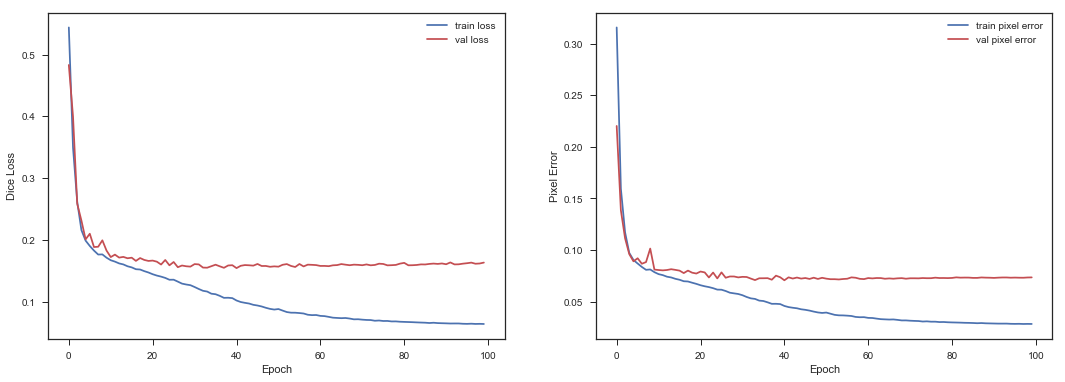

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Dice Loss')
ax[1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Pixel Error')
plt.show()

In [15]:
np.save(RESULT_PATH + 'history_Unet_fuse_v5.npy', results.history)

In [18]:
model_unet_fuse_v5.save_weights(WEIGHT_PATH + 'UNET_fuse_v5_weight.h5')
model_unet_fuse_v5.save(MODEL_PATH + 'UNET_fuse_v5_model.h5')
model_json = model_unet_fuse_v5.to_json()
with open(MODEL_PATH + 'UNET_fuse_v5_model.json', "w") as json_file:
    json_file.write(model_json)

In [12]:
y_pred = model_unet_fuse_v5.predict(X_test, batch_size=5)
result_fuse = y_pred[-1].astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

In [13]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v5_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v5_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

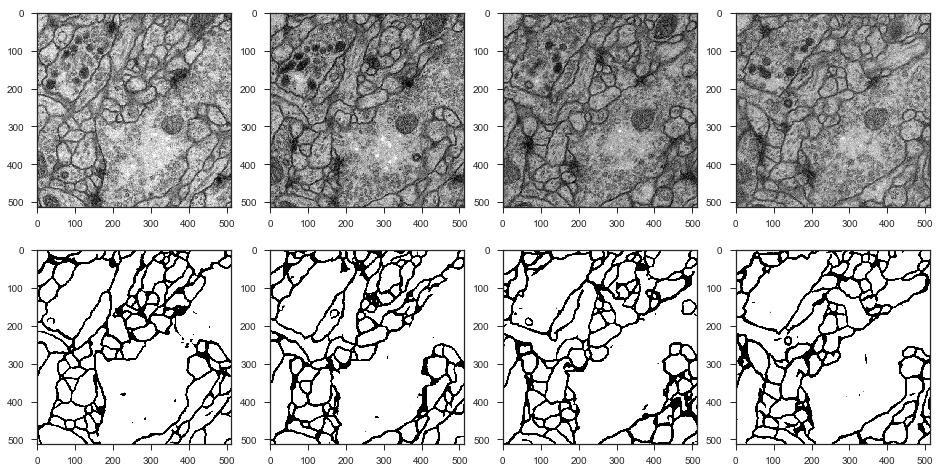

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()

Test with only flipped aug

In [23]:
X_train = np.load(DATA_PATH + 'X_train_aug_flip.npy')
y_train = np.load(DATA_PATH + 'y_train_aug_flip.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((120, 512, 512, 1), (120, 512, 512, 1), (30, 512, 512, 1))

In [24]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((108, 512, 512, 1), (12, 512, 512, 1), (108, 512, 512, 1), (12, 512, 512, 1))

In [17]:
model_fuse_v4 = u_res_side_fuse_v4(input_shape=(512, 512, 1))
model_fuse_v4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
pre-process (Lambda)            (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 32) 320         pre-process[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Acti

In [20]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_RES_Fuse_v4', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_fuse_v4.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_fuse_v4.fit(X_train, [y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=4, epochs=100, callbacks=callback_list, verbose=2)

Train on 297 samples, validate on 33 samples


Epoch 1/100


 - 69s - loss: 0.9678 - o1_loss: 0.2029 - o2_loss: 0.2095 - o3_loss: 0.1570 - o4_loss: 0.1393 - ofuse_loss: 0.2591 - ofuse_dice_coef: 0.3198 - ofuse_jaccard_coef: 0.1919 - ofuse_pixel_error: 0.5447 - val_loss: 0.8028 - val_o1_loss: 0.1670 - val_o2_loss: 0.1806 - val_o3_loss: 0.1209 - val_o4_loss: 0.1179 - val_ofuse_loss: 0.2164 - val_ofuse_dice_coef: 0.4914 - val_ofuse_jaccard_coef: 0.3271 - val_ofuse_pixel_error: 0.2929



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.29288, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 65s - loss: 0.5590 - o1_loss: 0.1236 - o2_loss: 0.1189 - o3_loss: 0.0947 - o4_loss: 0.0903 - ofuse_loss: 0.1315 - ofuse_dice_coef: 0.5883 - ofuse_jaccard_coef: 0.4187 - ofuse_pixel_error: 0.1825 - val_loss: 0.6597 - val_o1_loss: 0.1490 - val_o2_loss: 0.1334 - val_o3_loss: 0.1102 - val_o4_loss: 0.1215 - val_ofuse_loss: 0.1456 - val_ofuse_dice_coef: 0.6244 - val_ofuse_jaccard_coef: 0.4547 - val_ofuse_pixel_error: 0.1438



Epoch 00002: val_ofuse_pixel_error improved from 0.29288 to 0.14379, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/100


 - 65s - loss: 0.4527 - o1_loss: 0.0979 - o2_loss: 0.0951 - o3_loss: 0.0817 - o4_loss: 0.0802 - ofuse_loss: 0.0978 - ofuse_dice_coef: 0.6830 - ofuse_jaccard_coef: 0.5180 - ofuse_pixel_error: 0.1343 - val_loss: 0.4818 - val_o1_loss: 0.1078 - val_o2_loss: 0.0975 - val_o3_loss: 0.0873 - val_o4_loss: 0.0897 - val_ofuse_loss: 0.0995 - val_ofuse_dice_coef: 0.7007 - val_ofuse_jaccard_coef: 0.5392 - val_ofuse_pixel_error: 0.1288



Epoch 00003: val_ofuse_pixel_error improved from 0.14379 to 0.12877, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/100


 - 65s - loss: 0.4145 - o1_loss: 0.0899 - o2_loss: 0.0853 - o3_loss: 0.0772 - o4_loss: 0.0765 - ofuse_loss: 0.0856 - ofuse_dice_coef: 0.7186 - ofuse_jaccard_coef: 0.5597 - ofuse_pixel_error: 0.1183 - val_loss: 0.4709 - val_o1_loss: 0.1009 - val_o2_loss: 0.0927 - val_o3_loss: 0.0881 - val_o4_loss: 0.0962 - val_ofuse_loss: 0.0930 - val_ofuse_dice_coef: 0.7154 - val_ofuse_jaccard_coef: 0.5559 - val_ofuse_pixel_error: 0.1151



Epoch 00004: val_ofuse_pixel_error improved from 0.12877 to 0.11512, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/100


 - 66s - loss: 0.3869 - o1_loss: 0.0852 - o2_loss: 0.0781 - o3_loss: 0.0730 - o4_loss: 0.0727 - ofuse_loss: 0.0779 - ofuse_dice_coef: 0.7413 - ofuse_jaccard_coef: 0.5879 - ofuse_pixel_error: 0.1072 - val_loss: 0.4920 - val_o1_loss: 0.1051 - val_o2_loss: 0.0956 - val_o3_loss: 0.0948 - val_o4_loss: 0.0992 - val_ofuse_loss: 0.0973 - val_ofuse_dice_coef: 0.7378 - val_ofuse_jaccard_coef: 0.5842 - val_ofuse_pixel_error: 0.1177



Epoch 00005: val_ofuse_pixel_error did not improve
Epoch 6/100


KeyboardInterrupt: 

In [29]:
model_unet_fuse_v3.save_weights(WEIGHT_PATH + 'UNET_fuse_v3.1_weight.h5')
model_unet_fuse_v3.save(MODEL_PATH + 'UNET_fuse_v3.1_model.h5')
model_json = model_unet_fuse_v3.to_json()
with open(MODEL_PATH + 'UNET_fuse_v3.1_model.json', "w") as json_file:
    json_file.write(model_json)

In [48]:
model_unet_fuse_v3 = u_net_fuse_v3(input_shape=(512, 512, 1))
model_unet_fuse_v3.load_weights(WEIGHT_PATH + 'UNET_fuse_v3.1_weight.h5')

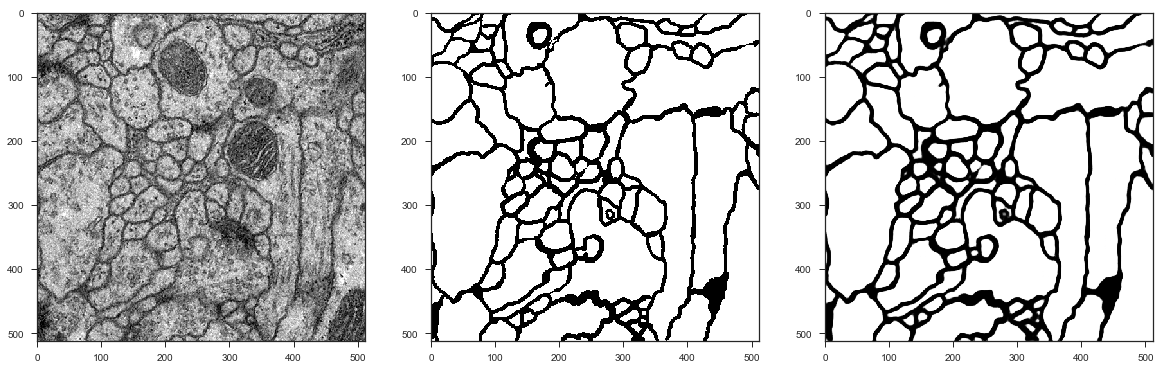

In [31]:
y_pred = model_unet_fuse_v3.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

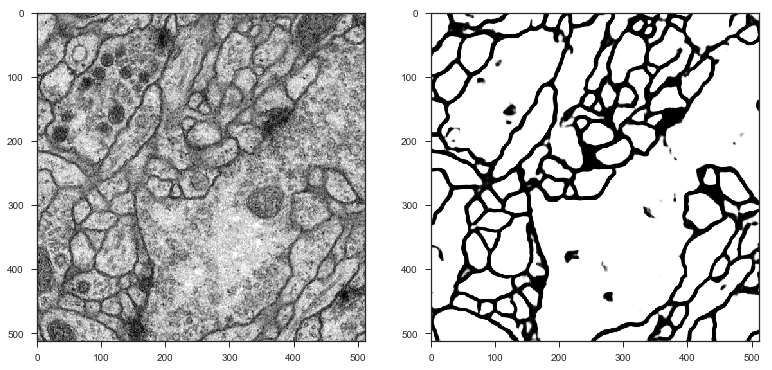

In [36]:
y_pred = model_unet_fuse_v3.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [50]:
y_pred = model_unet_fuse_v3.predict(X_test)
result_fuse = y_pred[-1].astype(np.float32)
result_02 = y_pred[-2].astype(np.float32)
result_fuse.shape, result_02.shape

((30, 512, 512, 1), (30, 512, 512, 1))

In [51]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v3.1_' + timestamp + '.tif', result_fuse, dtype=np.float32)

In [53]:
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v3.1_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

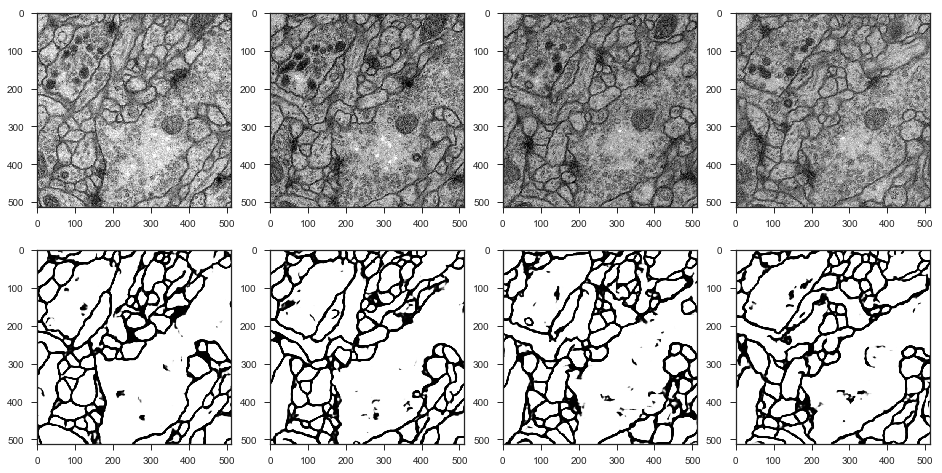

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()